In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
import statistics
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import holidays
from collections import defaultdict


import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 10, 3

import warnings
warnings.filterwarnings('ignore')

## Google trend keywords

In [5]:
sample = pd.read_csv('multiTimeline_seasonal.csv', skiprows=2)
sample.head()

,Week,rain coat,vegan ice cream,leather jacket,macaroni recipe,tooth ache,gift hamper,easter egg,chocolate box,christmas tree,Symptoms of COVID-19,pfizer vaccine,covishield vaccine,g20 summit 2023,russia ukraine news live update
0,5/19/2019,11,59,43,35,58,12,3,22,2,0,0,0,0,0
1,5/26/2019,19,70,39,38,60,11,3,22,3,0,0,0,0,0
2,6/2/2019,35,70,34,35,61,10,3,22,2,0,0,0,0,0
3,6/9/2019,62,76,38,36,59,14,3,20,2,0,0,0,0,0
4,6/16/2019,32,69,37,32,62,9,4,22,2,0,0,0,0,0


# Seasonality check 

## Monthly Seasonality

Keyword- rain coat


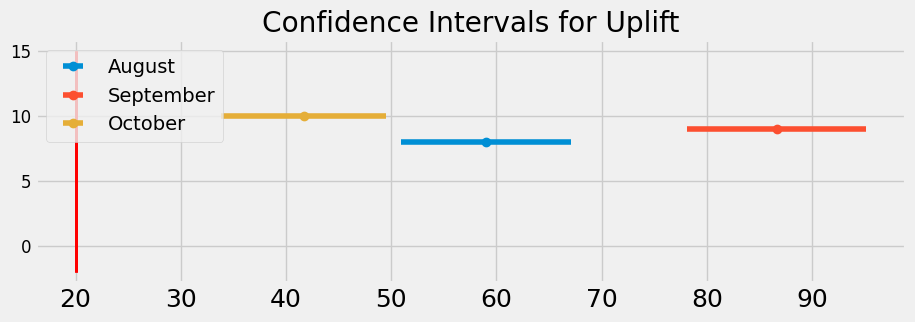

Seasonal on months- ['August' 'September' 'October']


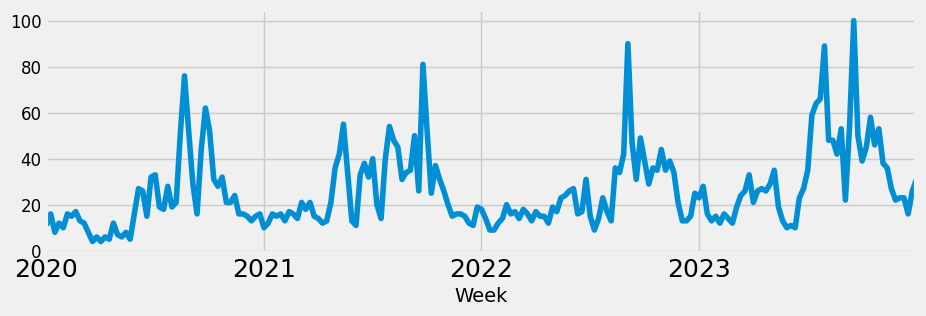

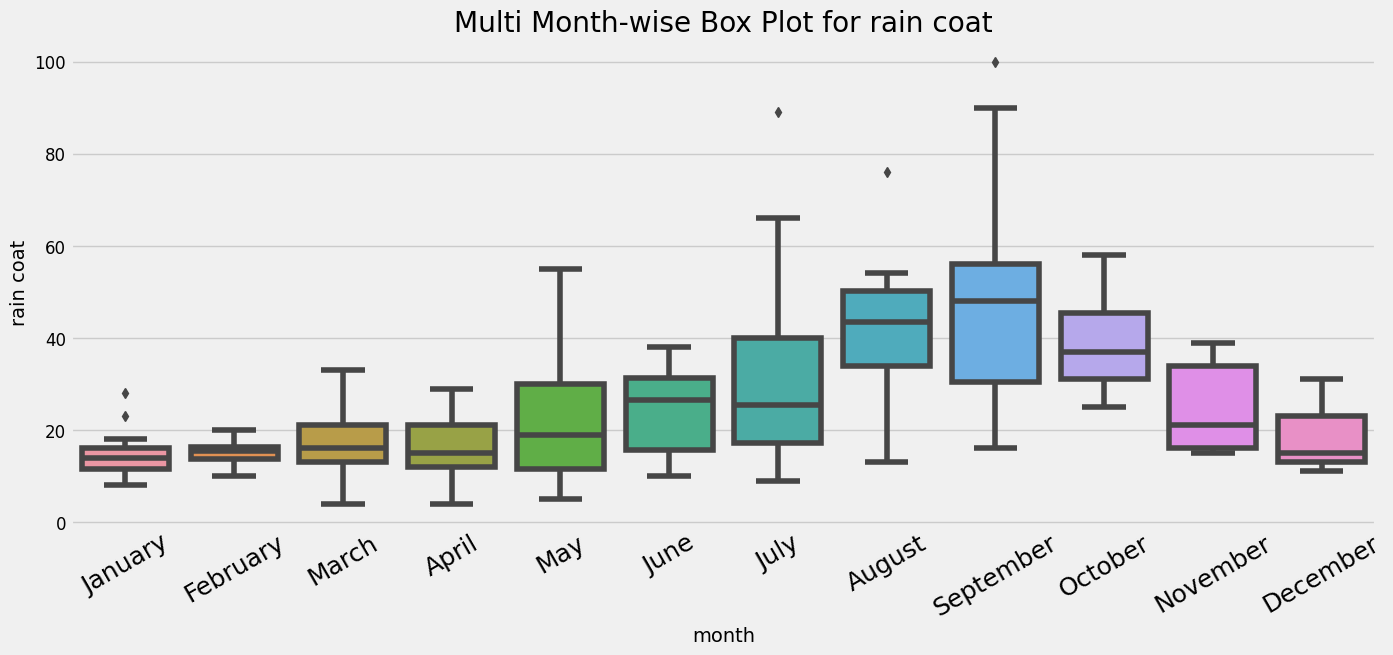

Keyword- vegan ice cream


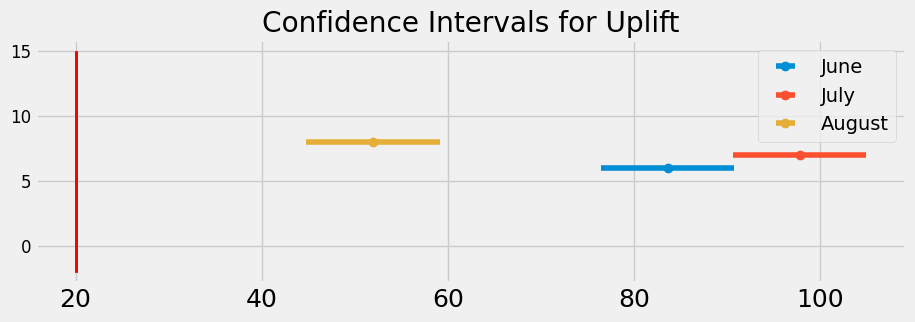

Seasonal on months- ['June' 'July' 'August']


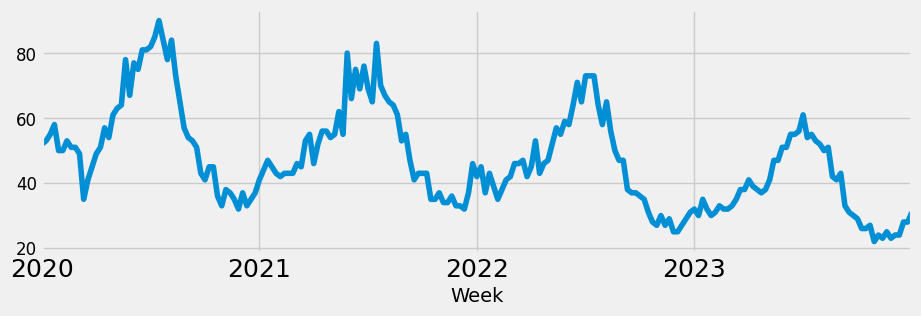

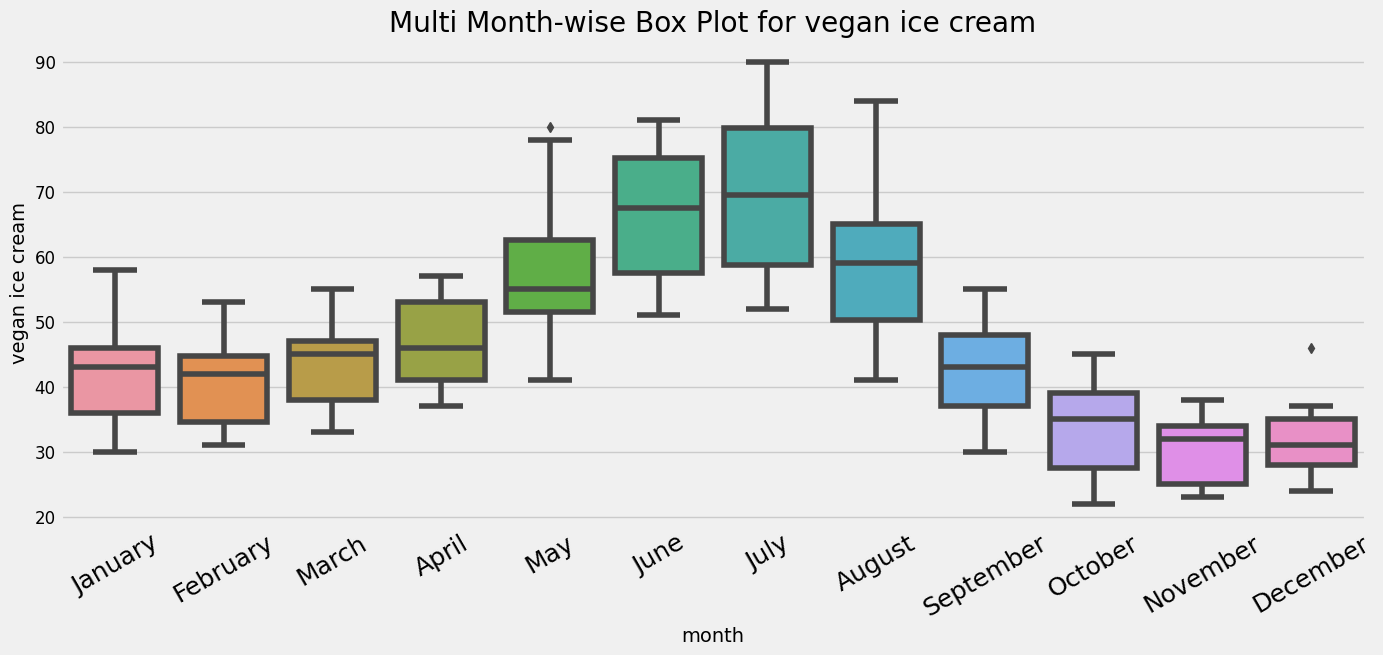

Keyword- leather jacket


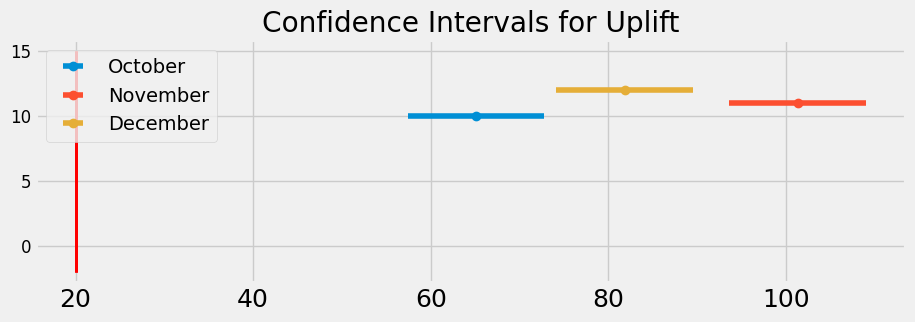

Seasonal on months- ['October' 'November' 'December']


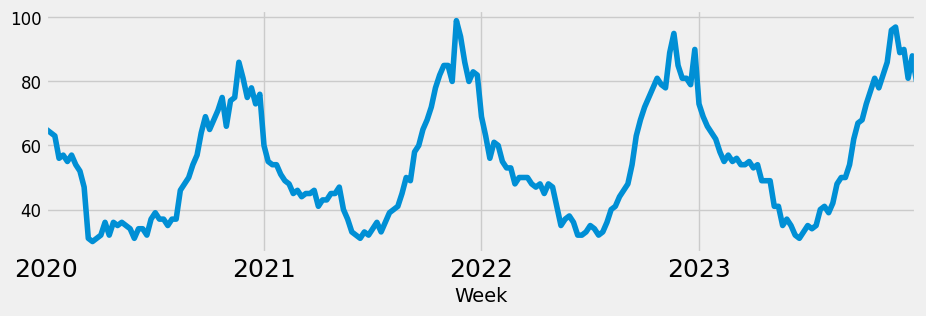

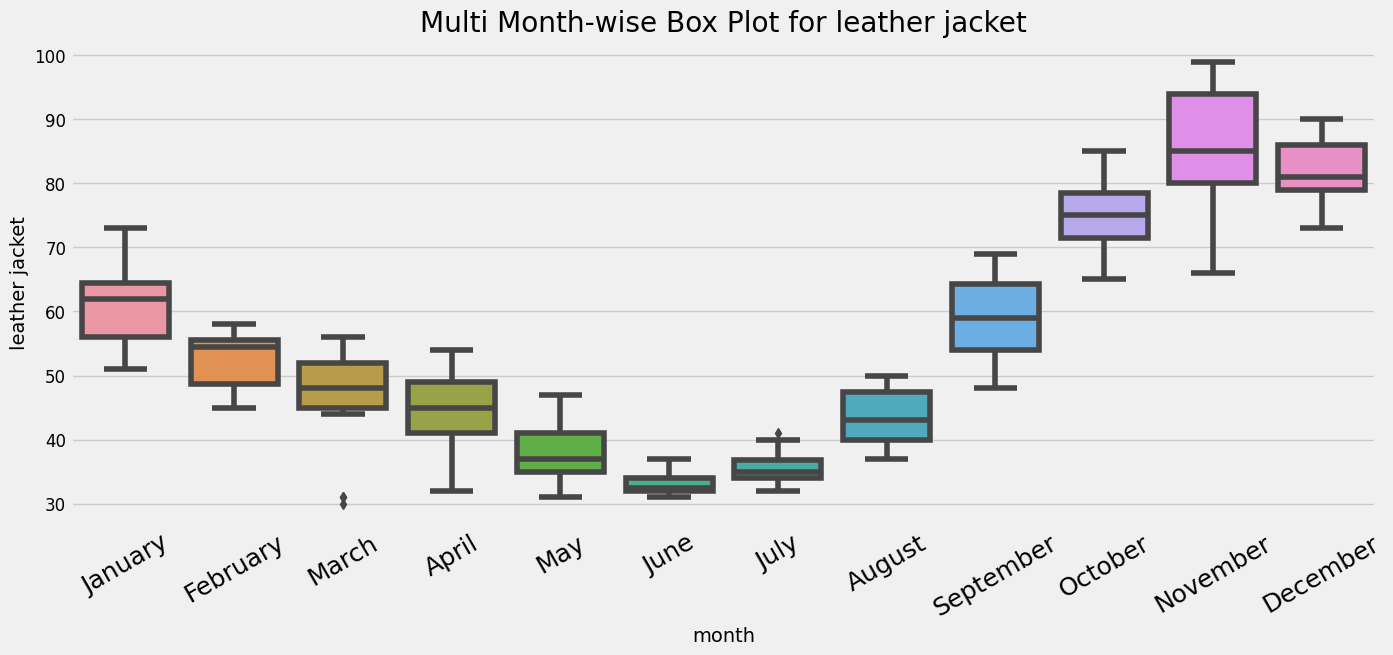

Keyword- macaroni recipe


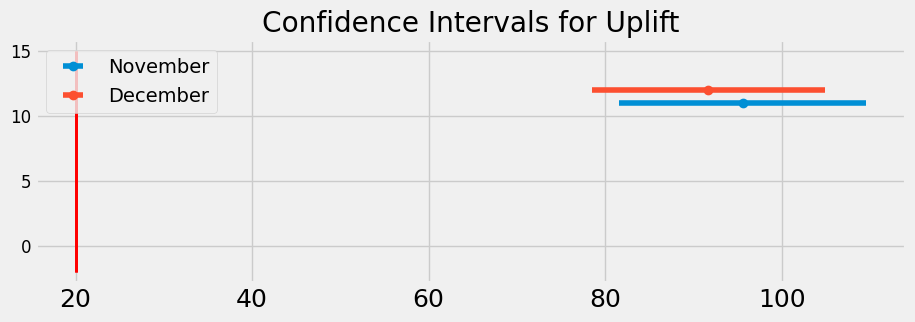

Seasonal on months- ['November' 'December']


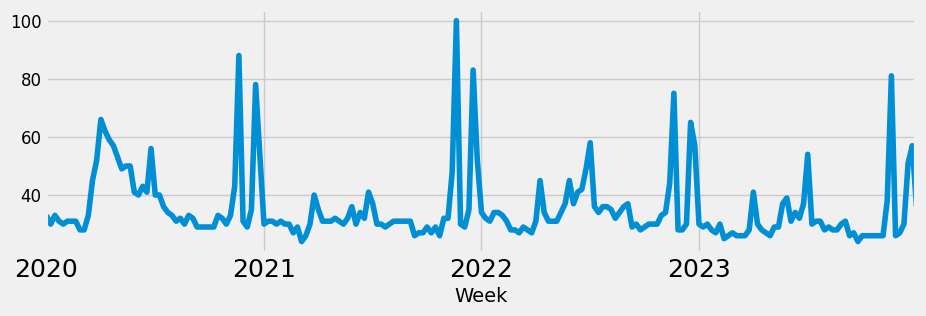

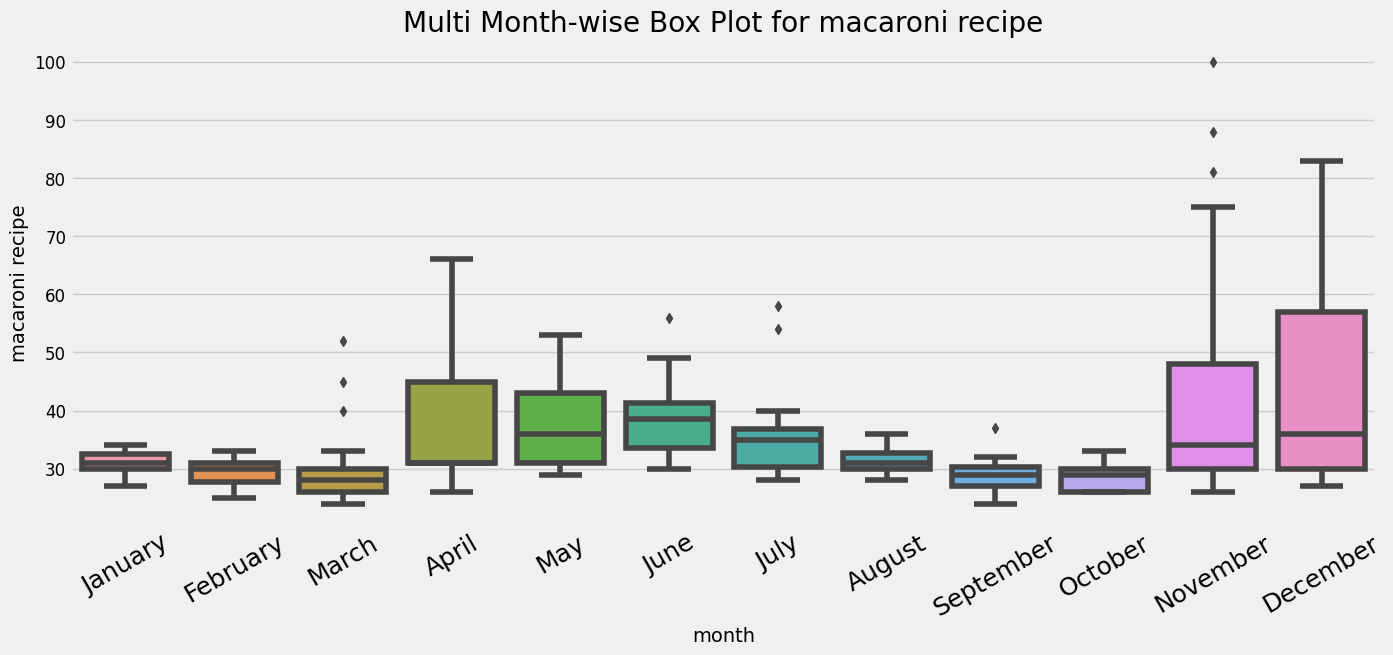

Keyword- tooth ache


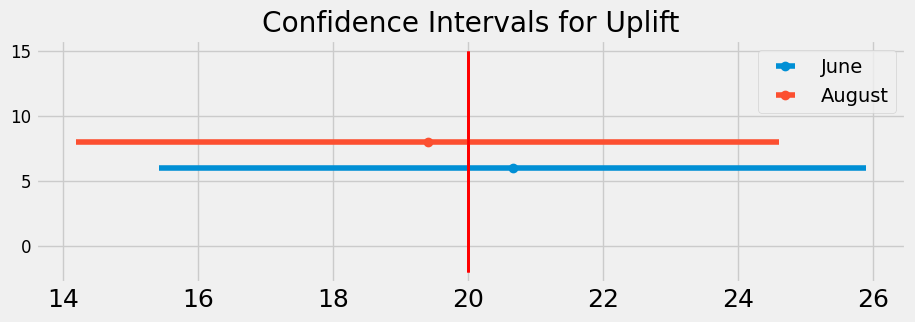

Seasonal on months- None


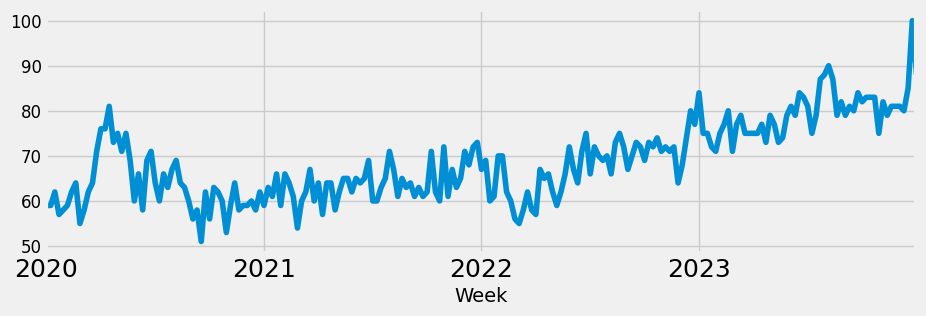

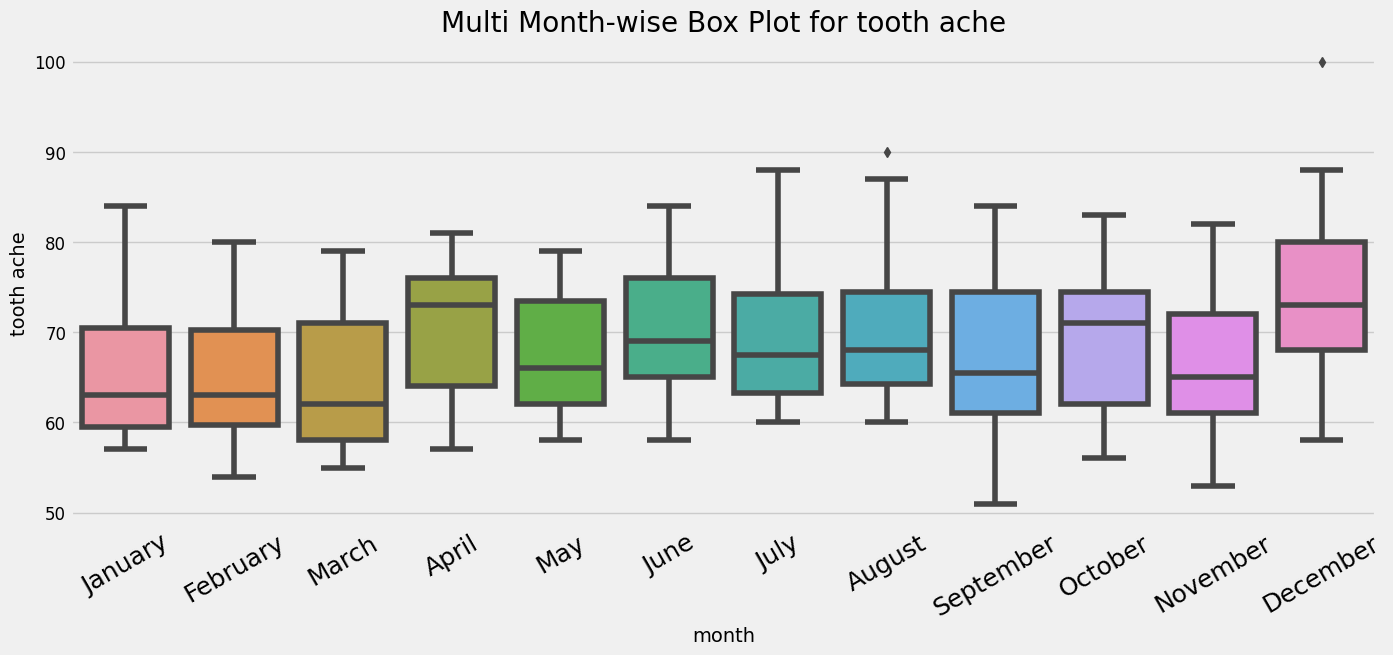

Keyword- gift hamper


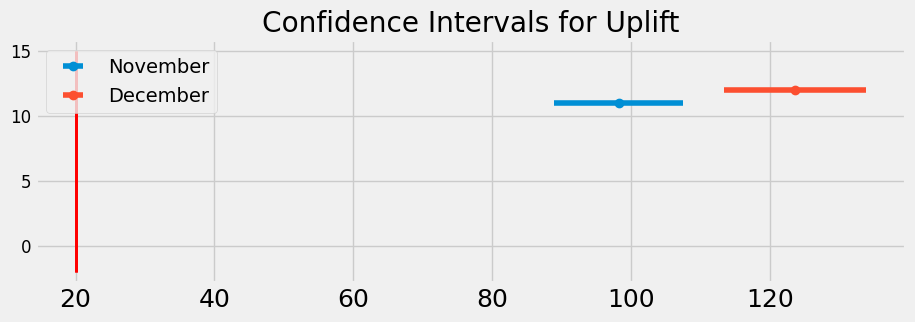

Seasonal on months- ['November' 'December']


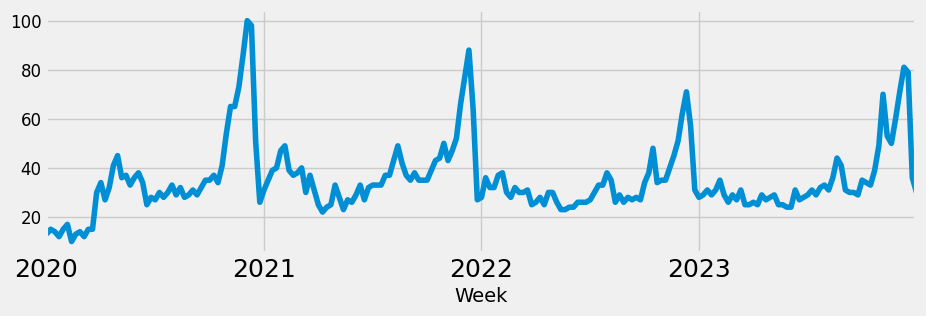

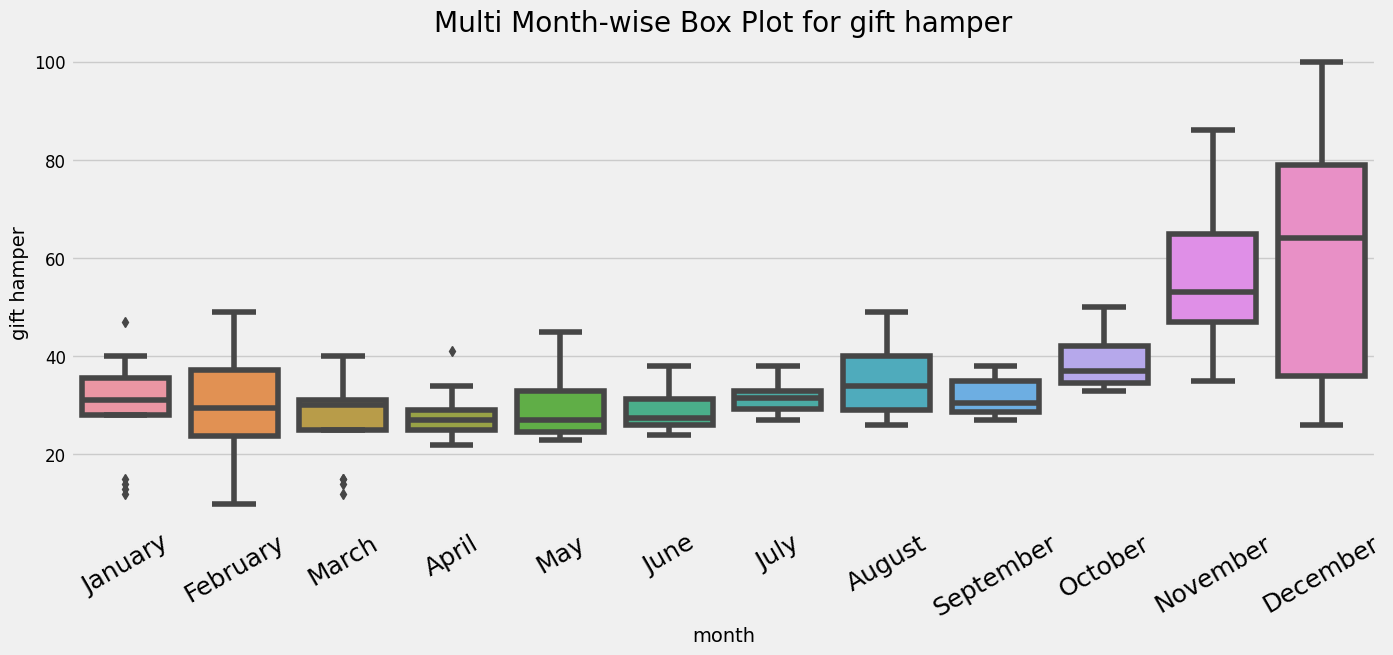

Keyword- easter egg


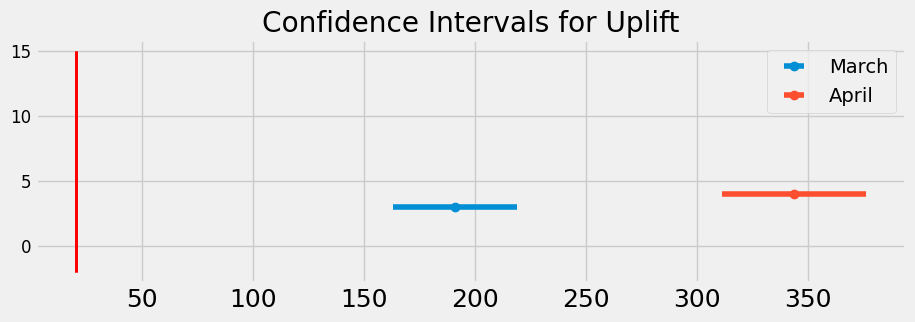

Seasonal on months- ['March' 'April']


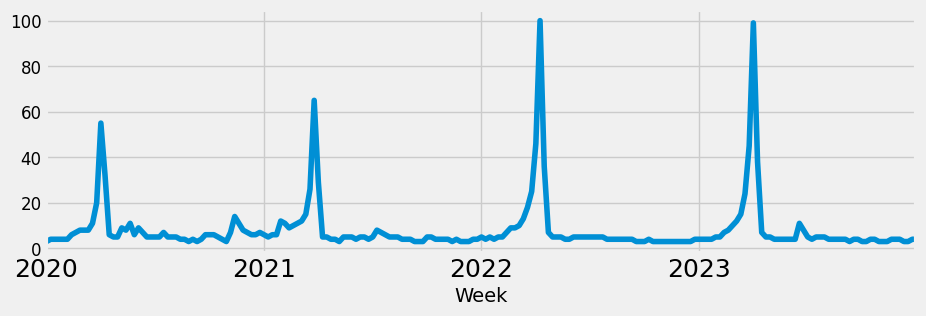

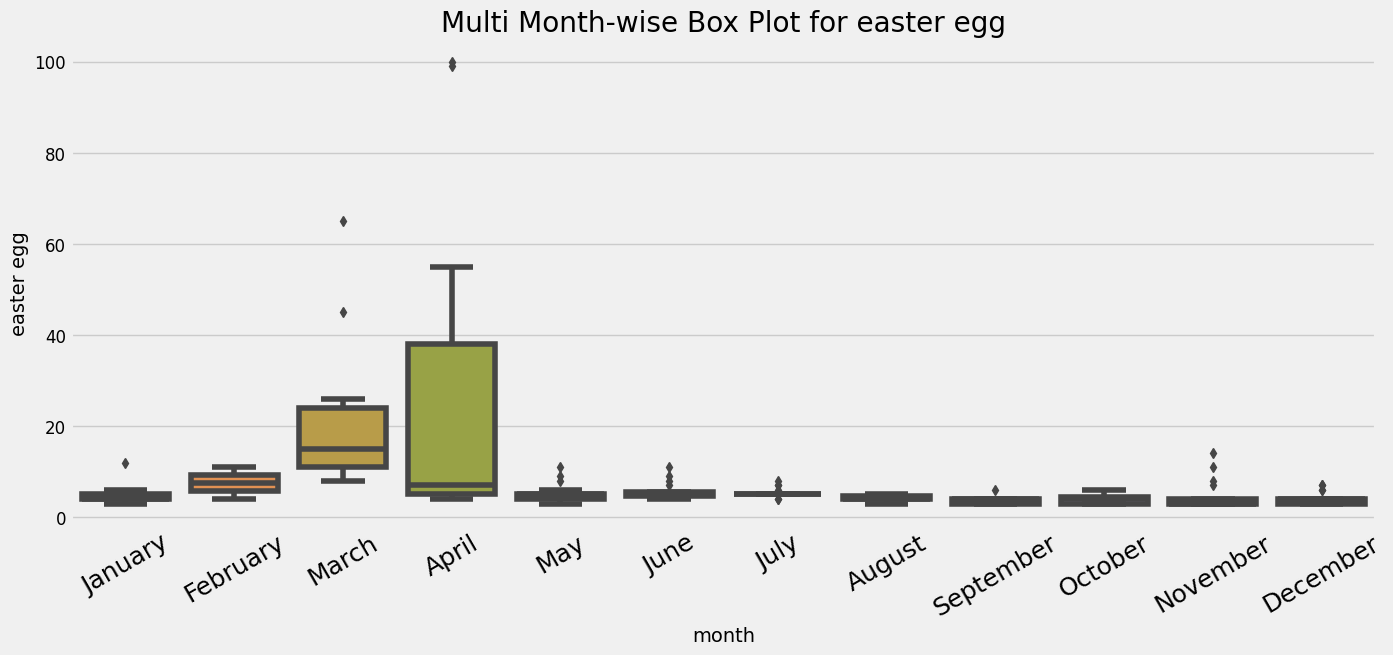

Keyword- chocolate box


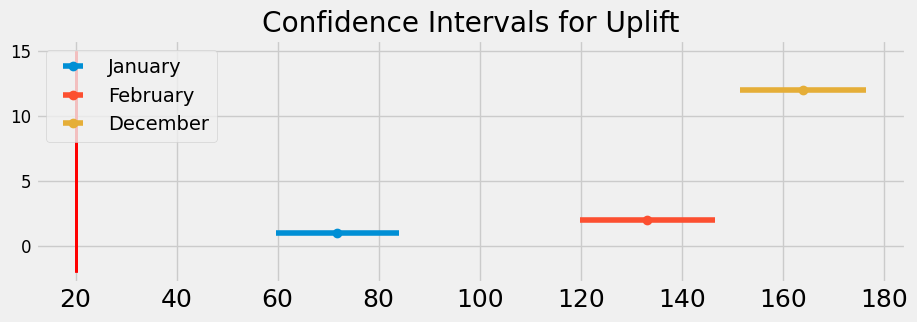

Seasonal on months- ['January' 'February' 'December']


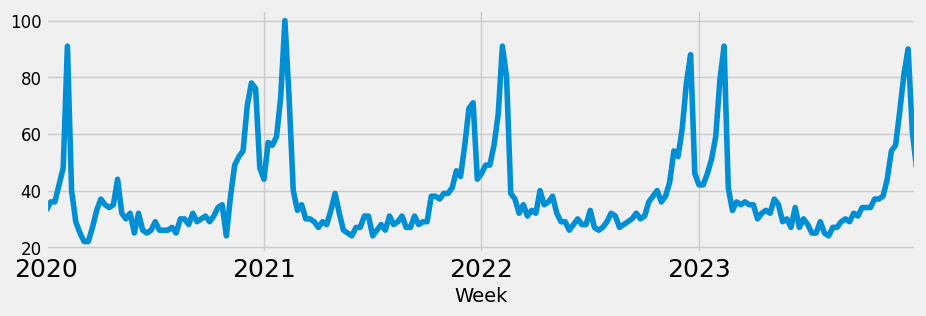

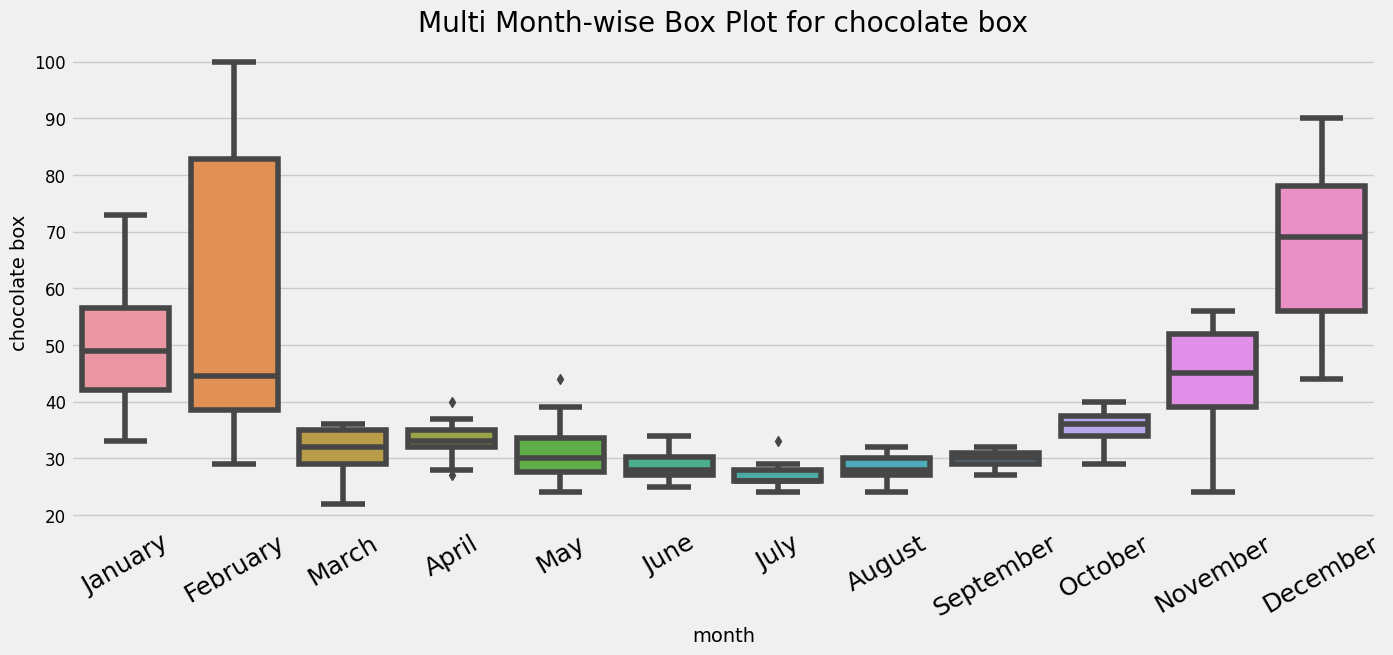

Keyword- christmas tree


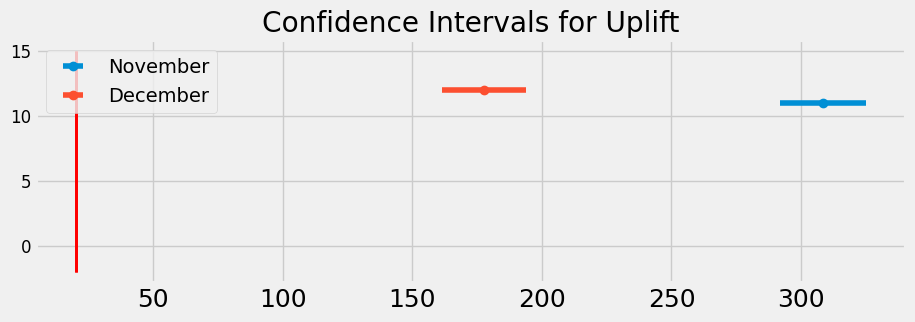

Seasonal on months- ['November' 'December']


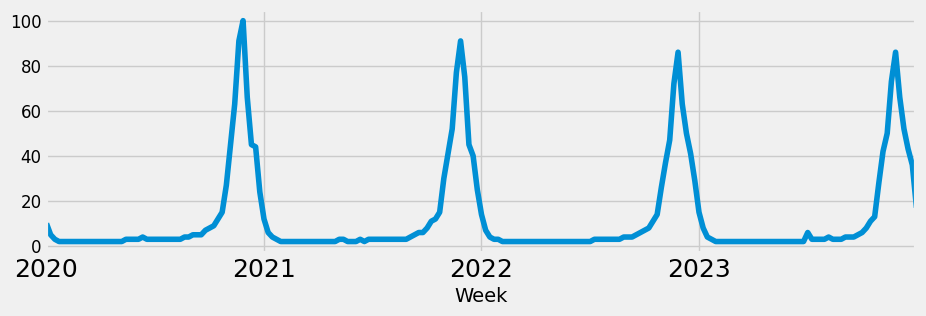

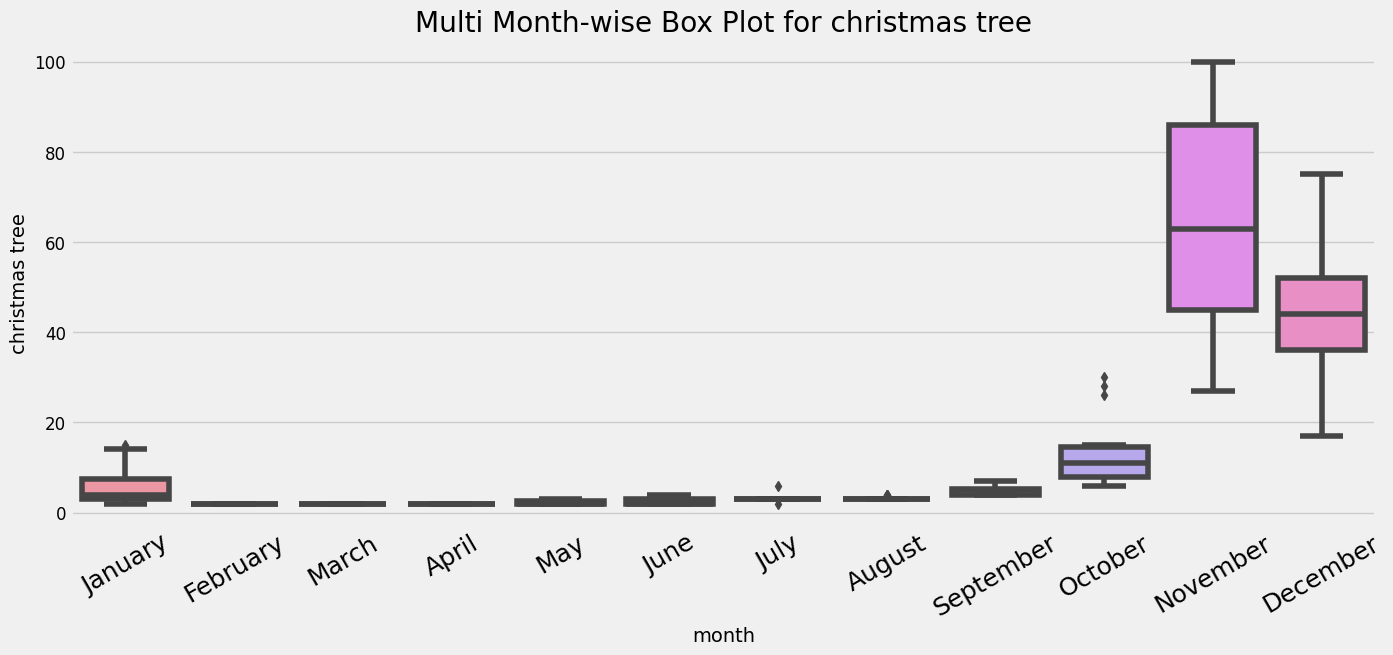

Keyword- Symptoms of COVID-19


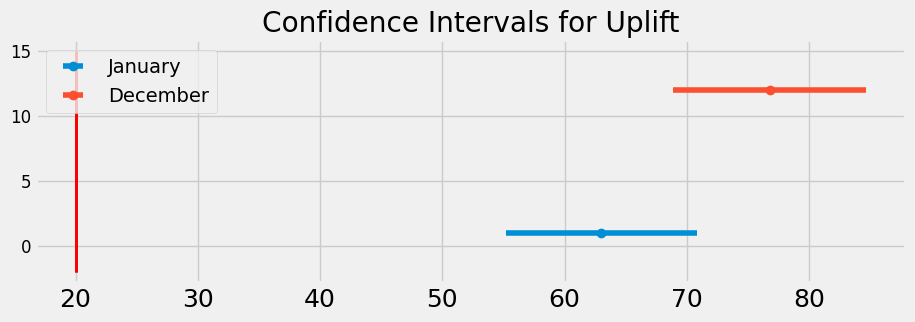

Seasonal on months- ['January' 'December']


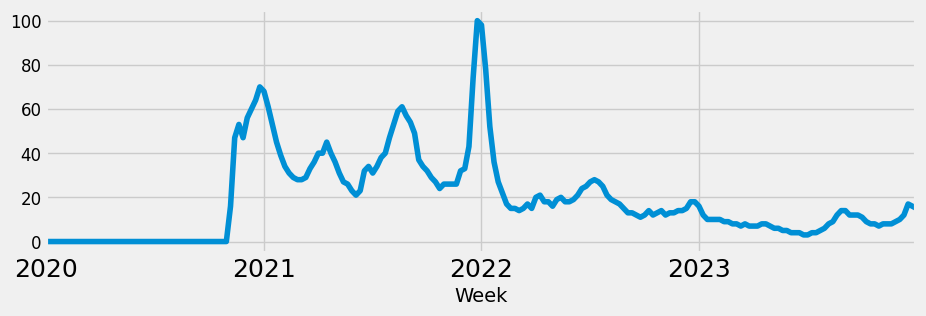

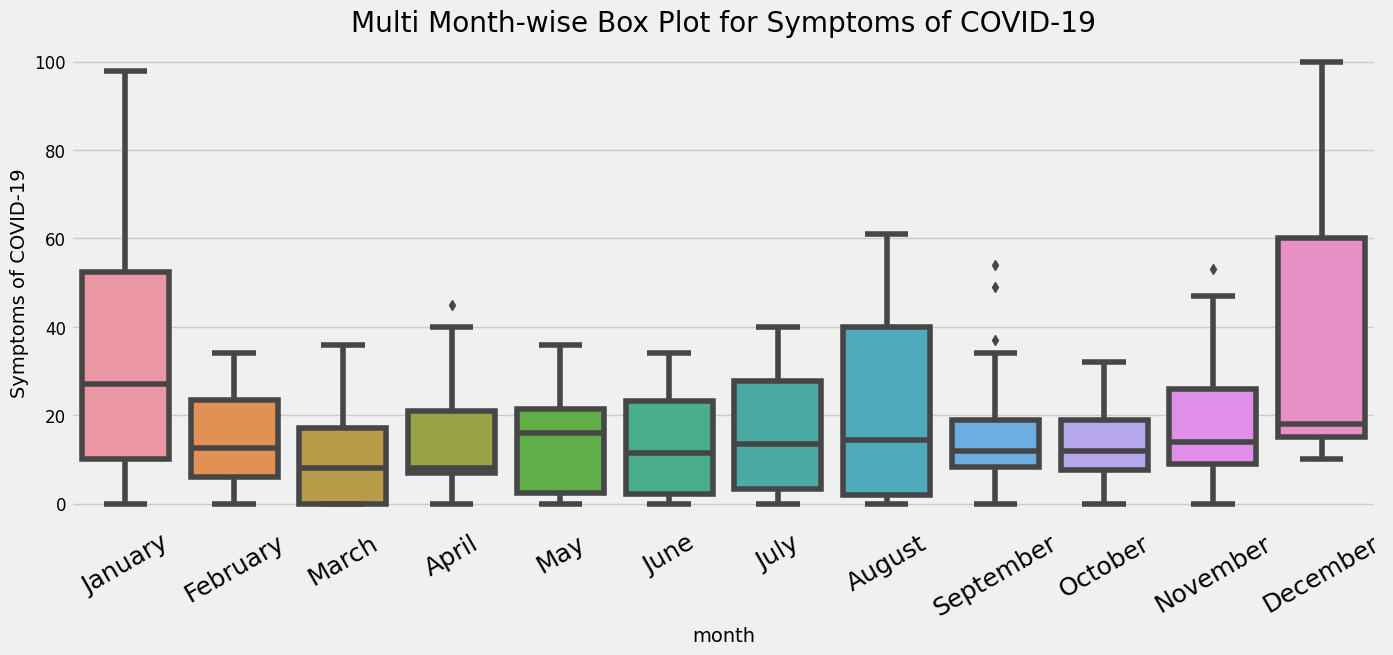

Keyword- pfizer vaccine
Seasonal on months- None


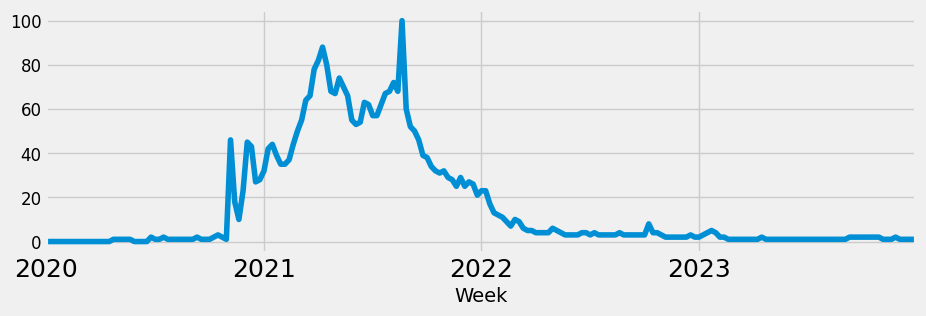

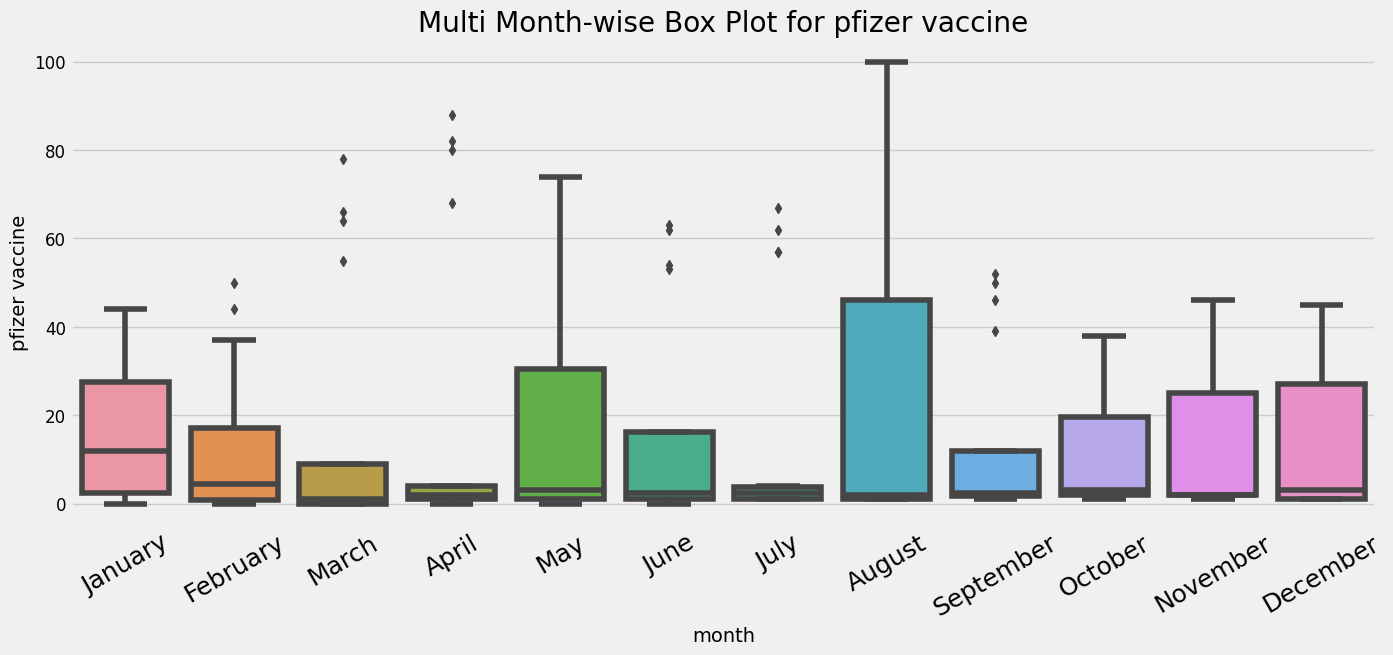

Keyword- covishield vaccine
Seasonal on months- None


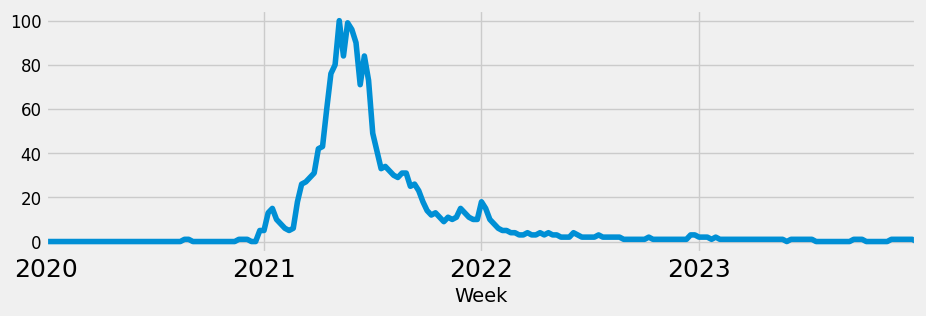

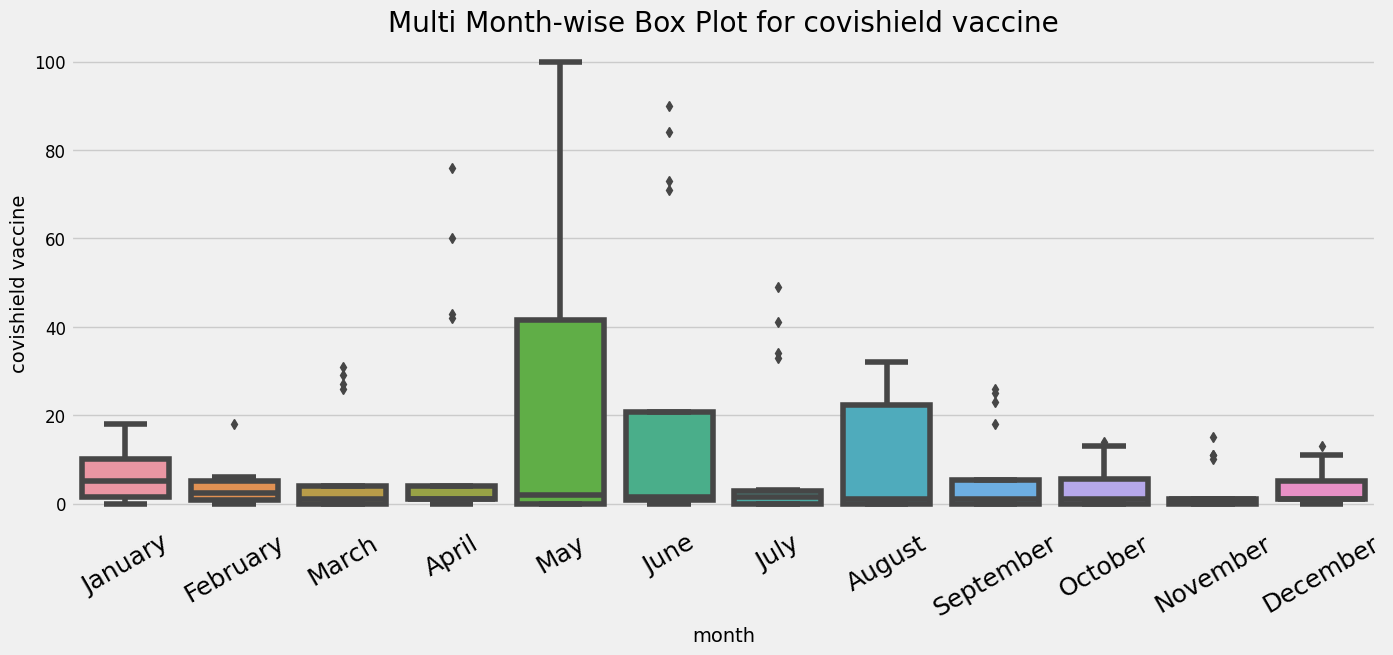

Keyword- g20 summit 2023
Seasonal on months- None


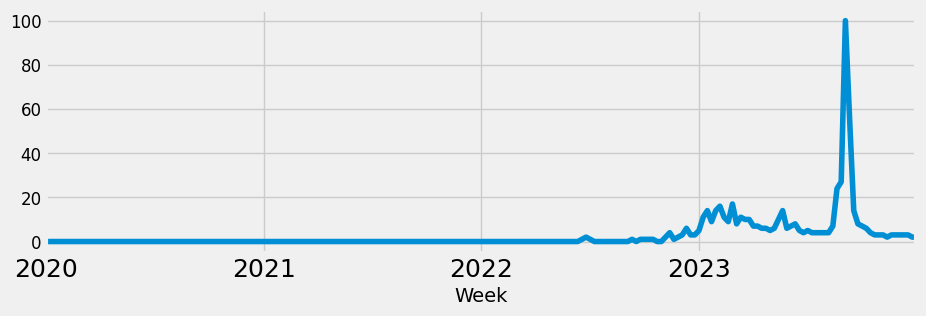

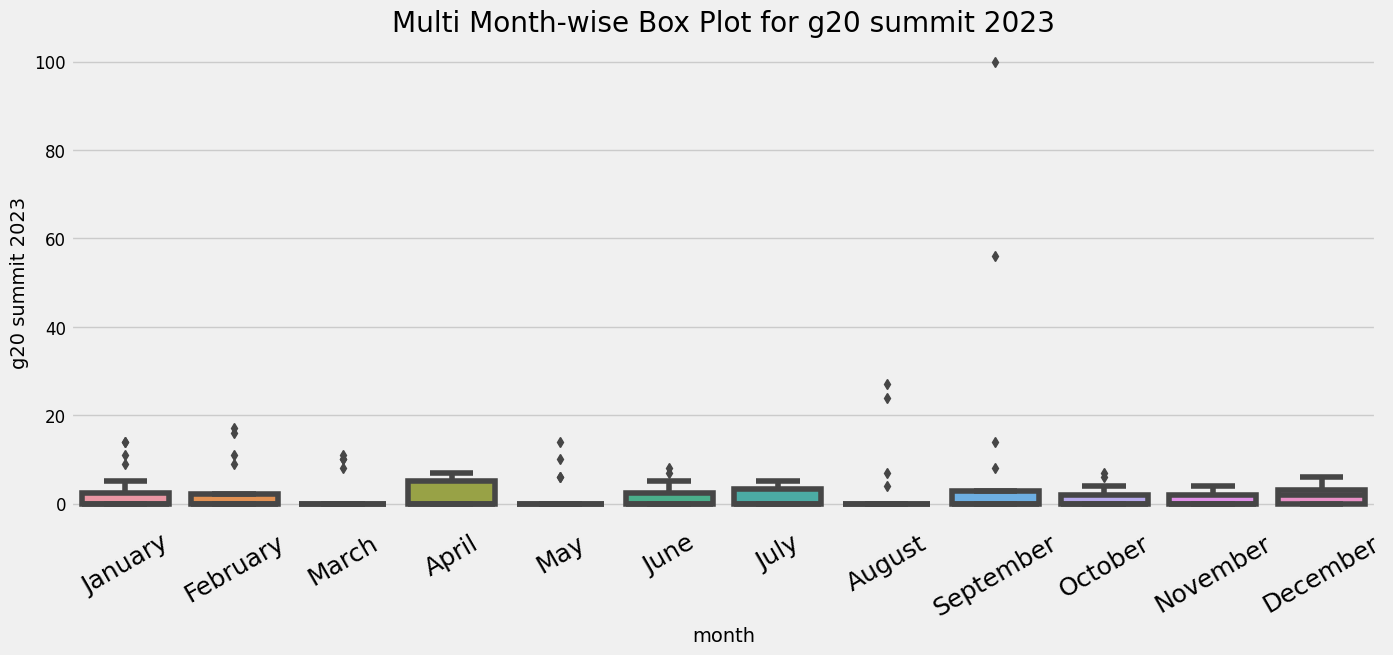

Keyword- russia ukraine news live update
Seasonal on months- None


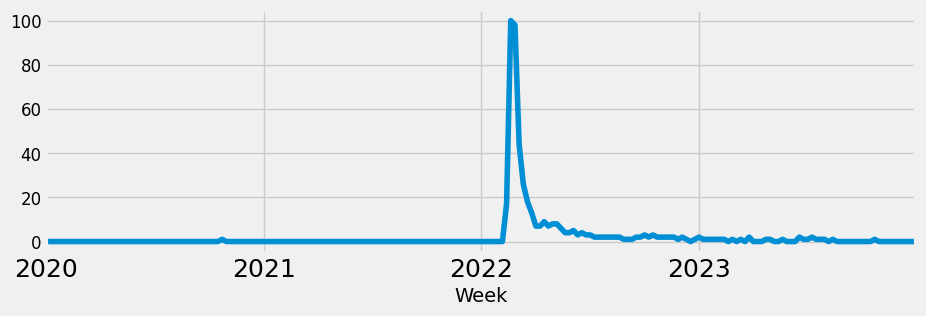

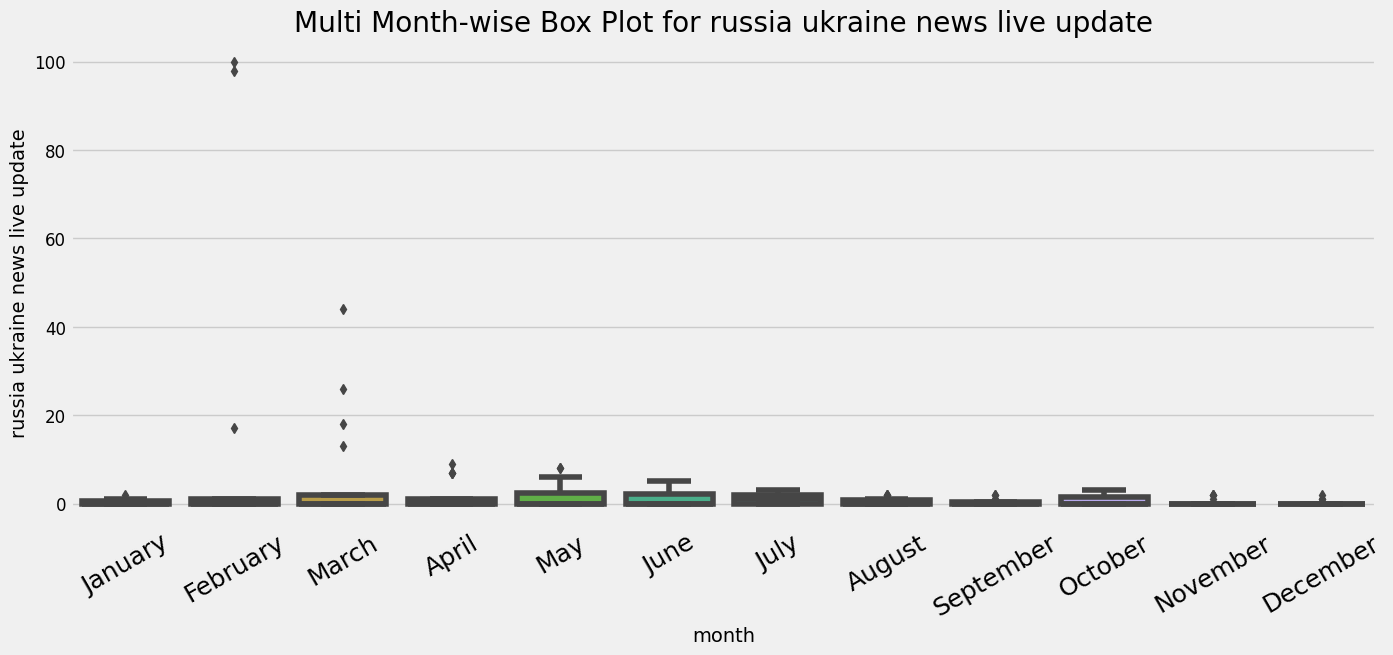

keyword      score      pvalue  lower_bound
month                                                                 
April     14            easter egg  99.999994   99.999988   311.295368
August    0              rain coat  53.077171   99.986005    50.972231
          5        vegan ice cream  51.957122   99.983150    44.765303
December  19        christmas tree  72.969782   99.999994   161.312085
          17         chocolate box  71.197233  100.000000   151.476677
          12           gift hamper  64.333125  100.000000   113.389618
          10       macaroni recipe  58.018959   99.958525    78.469100
          8         leather jacket  57.256765   99.999988    74.124863
          21  Symptoms of COVID-19  56.308360   99.999893    68.862682
February  16         chocolate box  65.491910   99.999895   119.819694
January   15         chocolate box  54.564712   99.836534    59.640873
          20  Symptoms of COVID-19  53.839156   99.997962    55.167102
July      4        vegan ice cream  60.234135  100.000000    90.645439
June      3        vegan ice cream  57.672632   99.999998    76.432365
March     13            easter egg  73.245564   99.950480   162.979696
November  18        christmas tree  96.518303  100.000000   291.976383
          7         leather jacket  60.757866  100.000000    93.551483
          11           gift hamper  59.924439   99.999987    88.927059
          9        macaroni recipe  58.570908   99.948798    81.558701
October   6         leather jacket  54.249232   99.999285    57.438833
          2              rain coat  49.783521   99.567042    33.859020
September 1              rain coat  57.981759   99.999938    78.147791

In [9]:
def ab_test(seasonal_data, seasonal_months, verbose):
    final_seasonal_months = pd.DataFrame()

    # scaling to 0 to 1
    scaler = MinMaxScaler().fit(seasonal_data[[keyword+'_cycle']])
    seasonal_data['min_max'] = scaler.transform(seasonal_data[[keyword+'_cycle']])

    # Conducting two-sample t test
    for seasonal_month in seasonal_months:
        data_b = seasonal_data[seasonal_data.month==seasonal_month]
        data_a = seasonal_data
        
        # get length of data
        n2 = len(data_b)
        n1 = len(data_a)

        # get variance of data
        var1 = statistics.variance(data_a['min_max'])
        var2 = statistics.variance(data_b['min_max'])
        
        # get mean values
        m1 = data_a['min_max'].mean()
        m2 = data_b['min_max'].mean()
        relative_mean = m2-m1
        
        # get pooled standard deviation
        pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
        
        # z critical for 95% confidence
        z_critical = stats.norm.ppf(q = 0.975)
        # Note: We use q = 0.975 to get the desired z-critical value instead of q = 0.95 because the distribution has two tails.
        
        # get lower and upper bounds for confidence interval
        lower_bound = relative_mean-z_critical*pooled_sd/np.sqrt(n1+n2)
        lower_bound = lower_bound*100/m1
        upper_bound = relative_mean+z_critical*pooled_sd/np.sqrt(n1+n2)
        upper_bound = upper_bound*100/m1
        
        # perform 2 student t test
        pvalue = ttest_ind(data_a['min_max'], data_b['min_max'])[1]
        
        months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August',
         9:'September', 10:'October', 11:'November', 12:'December'}
        
        # filter data if MVP>20 and data_a and data_b are statistically different
        if pvalue<0.05 and lower_bound>20:
            # print(f'month- {seasonal_month} is seasonal')
            # print('95% confident for Minimum Uplift-', round(lower_bound, 2), '%')
            final_seasonal_months = pd.concat([final_seasonal_months, 
            pd.DataFrame.from_dict([{'month':months[seasonal_month], 'pvalue':(1-pvalue)*100, 'lower_bound':lower_bound}])])
        
        
        if verbose>1:
            plt.errorbar(y=seasonal_month, 
                        x=relative_mean*100/m1, 
                        xerr=(upper_bound-lower_bound)/2,
                        fmt='o', label=months[seasonal_month])

            plt.vlines(ymin=-2, ymax=15,
                    x=m1*.2*100/m1, 
                    linewidth=2.0,
                    color="red");
            plt.legend()
            plt.title('Confidence Intervals for Uplift')

    if verbose>1:
         plt.show()

    return final_seasonal_months


seasonal_data = pd.DataFrame()
rcParams['figure.figsize'] = 10, 3
for keyword in ['rain coat', 'vegan ice cream', 'leather jacket',
       'macaroni recipe', 'tooth ache', 'gift hamper', 'easter egg',
       'chocolate box', 'christmas tree', 'Symptoms of COVID-19',
       'pfizer vaccine', 'covishield vaccine', 'g20 summit 2023',
       'russia ukraine news live update']:

    print('Keyword-', keyword)
    sample_ = sample.copy()
    sample_['month'] = pd.DatetimeIndex(sample_['Week']).month
    sample_['year'] = pd.DatetimeIndex(sample_['Week']).year
    sample_ = sample_[(sample_['year']>=2020) & (sample_.year<2024)]
    
    sample_.index = pd.to_datetime(sample_['Week'])
    sample_.index.freq = 'W'

    gdp_cycle, gdp_trend = hpfilter(sample_[keyword], lamb=129600)
    # gdp_cycle.plot(label='hp filter')
    seasonal_component = seasonal_decompose(sample_[keyword]).seasonal

    # get overall mean of monthly data
    overall_mean_hp = gdp_cycle.resample('M').mean().quantile(0.75)#.mean()
    # overall_mean_sd = seasonal_component.resample('M').mean().mean()

    # get data on month frequency
    gdp_cycle_monthly = gdp_cycle.resample('M').mean()
    seasonal_component_monthly = seasonal_component.resample('M').mean()

    # get monthly mean of data
    gdp_cycle_monthly = pd.DataFrame(gdp_cycle_monthly).reset_index()
    gdp_cycle_monthly['month'] = pd.DatetimeIndex(gdp_cycle_monthly['Week']).month

    seasonal_component_monthly = pd.DataFrame(seasonal_component_monthly).reset_index()
    seasonal_component_monthly['month'] = pd.DatetimeIndex(seasonal_component_monthly['Week']).month

    # get count of months where data > overall mean
    month_count = gdp_cycle_monthly[gdp_cycle_monthly[keyword+'_cycle']>overall_mean_hp].month.value_counts()

    # keep only months where count > number of years/2
    eligible_months = list(month_count[month_count>2].index.values)

    # get monthly mean of data
    gdp_monthly_average = gdp_cycle_monthly.groupby(['month'])[keyword+'_cycle'].mean()

    # get seasonal months based on monthly mean value > overall mean value across year
    gdp_seasonal_months = list(gdp_monthly_average[gdp_monthly_average>overall_mean_hp].index.values)   
    seasonal_months = [month for month in gdp_seasonal_months if month in eligible_months]

    # t test between seasonal months vs rest of the data to make sure seasonal months are unique
    gdp_cycle = pd.DataFrame(gdp_cycle).reset_index()
    gdp_cycle['month'] = pd.DatetimeIndex(gdp_cycle['Week']).month

    # run a/b test to get final seasonal months
    seasonal_months = ab_test(gdp_cycle, seasonal_months, verbose=2)
    if len(seasonal_months)>0:
      seasonal_months['keyword'] = keyword
      seasonal_data = pd.concat([seasonal_data, seasonal_months])
      #  temp = []
      #  for seasonal_month in seasonal_months:
      #      if ttest_ind(gdp_cycle[gdp_cycle.month==seasonal_month][keyword+'_cycle'], gdp_cycle[~gdp_cycle.month.isin(seasonal_months)][keyword+'_cycle'])[1]<0.05:
      #          temp.append(seasonal_month)
      #  seasonal_months = temp

      months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August',
         9:'September', 10:'October', 11:'November', 12:'December'}
      print('Seasonal on months-', seasonal_months['month'].values)
      # print('Seasonal on months-', list(map(lambda x: months[x], seasonal_months['month'].values.tolist())))
    
    else:
      print('Seasonal on months- None')
    
   #  seasonal_component.plot(label='seasonal decompose')
    sample_[keyword].plot(label='original data')
    
    # plt.title(f"{keyword}")
    # plt.xticks(rotation=30)
    # plt.show()

    sample_['month-year'] = sample_['year'].apply(str)+'-'+sample_['month'].apply(str)
    sample_['week'] = pd.DatetimeIndex(sample_['Week']).week

    sample_['month'] = sample_['month'].map(lambda x: months[x])


    plt.figure(figsize=(15,6))
    matplotlib.rcParams['xtick.labelsize'] = 18
    sns.boxplot(x='month', y=keyword, data=sample_).set_title(f"Multi Month-wise Box Plot for {keyword}")
    plt.xticks(rotation=30)
    plt.show()

scaler = MinMaxScaler()
seasonal_data['lower_bound_scaled'] = scaler.fit_transform(seasonal_data[['lower_bound']])*100
seasonal_data['score'] = (seasonal_data['pvalue']+seasonal_data['lower_bound_scaled'])/2
# seasonal_data.sort_values(['month', 'score'], ascending=False).reset_index(drop=True)[['month', 'keyword', 'score', 'pvalue', 'lower_bound']]
seasonal_data.reset_index(drop=True).groupby('month').apply(lambda x: x.sort_values('score', ascending=False))[['keyword', 'score', 'pvalue', 'lower_bound']]
    

## Weekly Seasonality

Seasonal on weeks- [33 35 39 40]


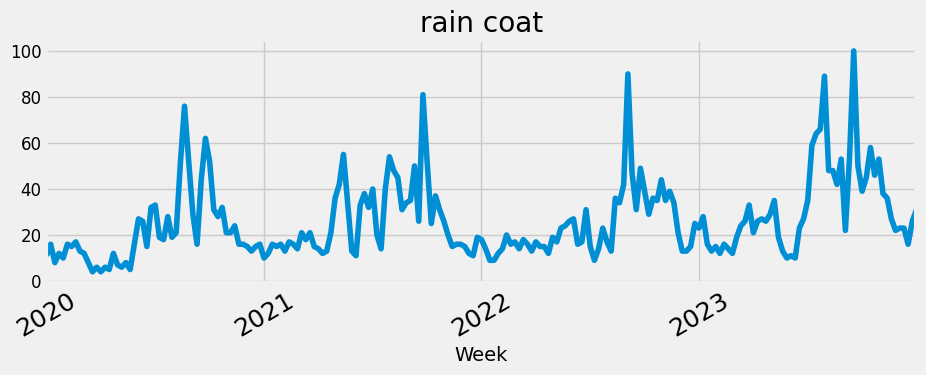

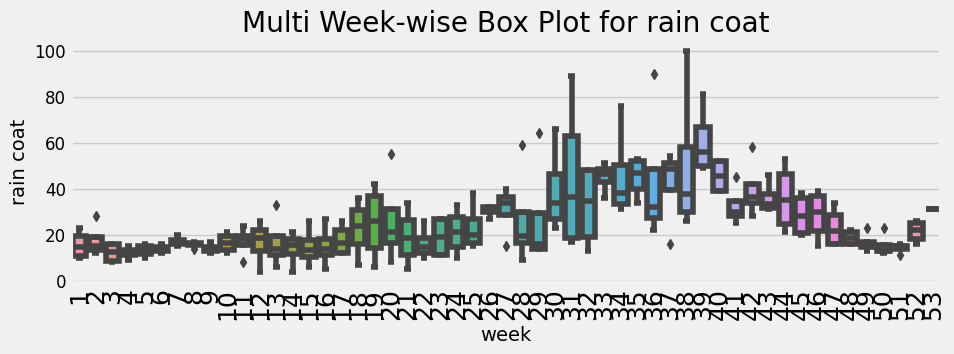

Seasonal on weeks- [22 23 24 25 26 27 28 29 30 31 32 33]


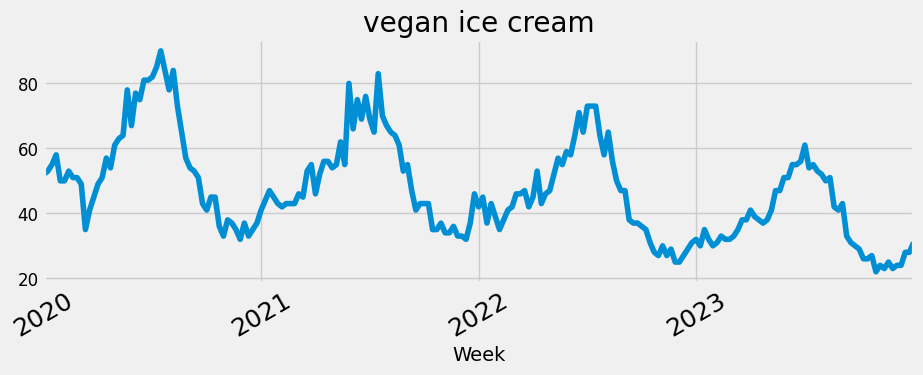

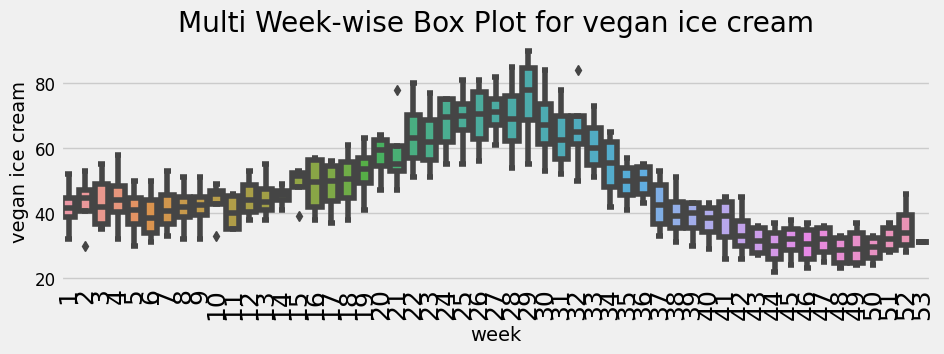

Seasonal on weeks- [42 43 44 45 46 47 48 49 50 51 52]


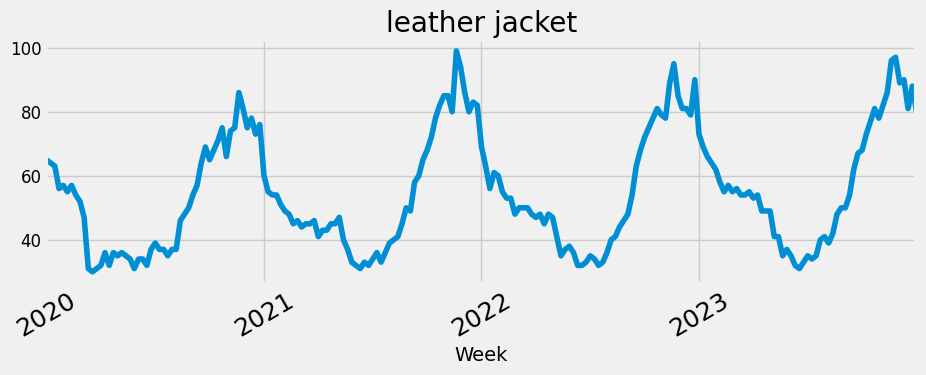

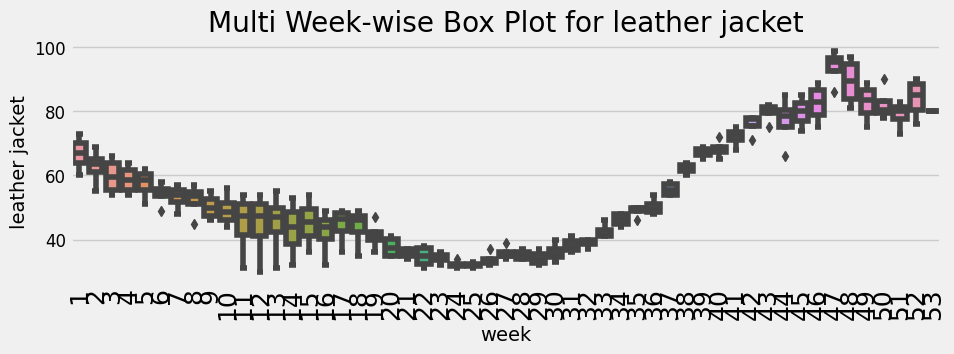

Seasonal on weeks- [27 47 51 52]


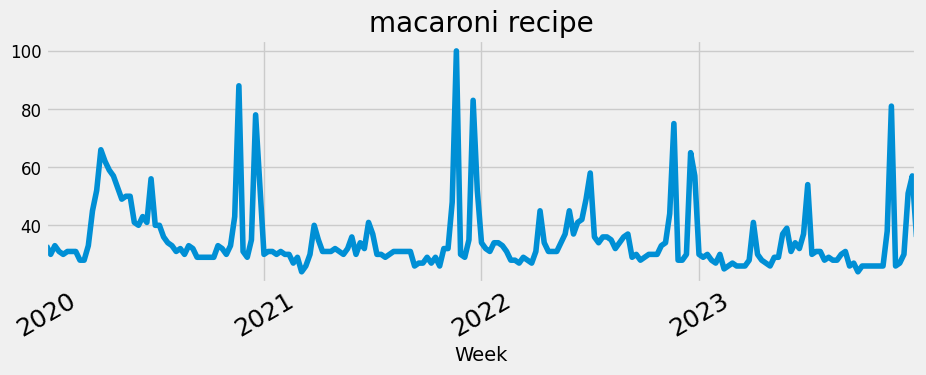

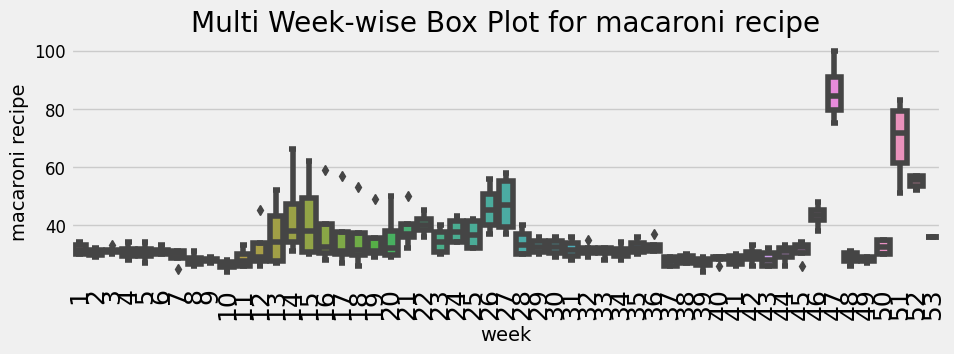

Seasonal on weeks- [26 31 52]


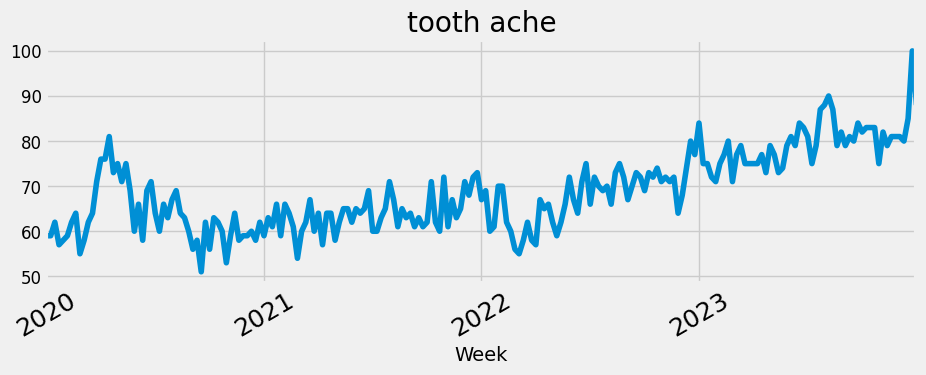

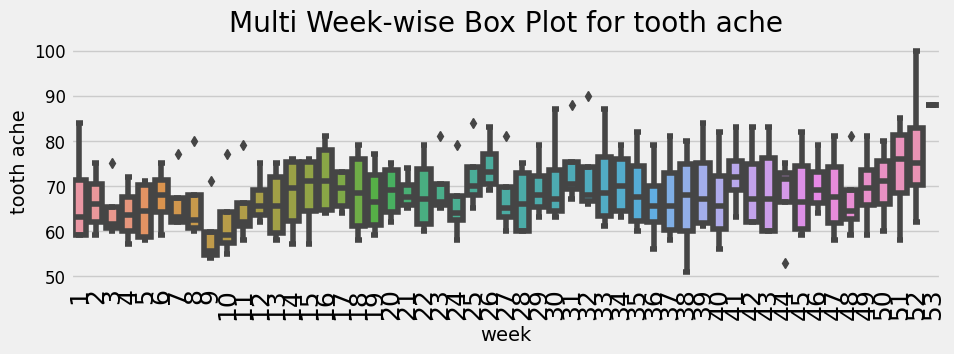

Seasonal on weeks- [45 46 47 48 49 50 51]


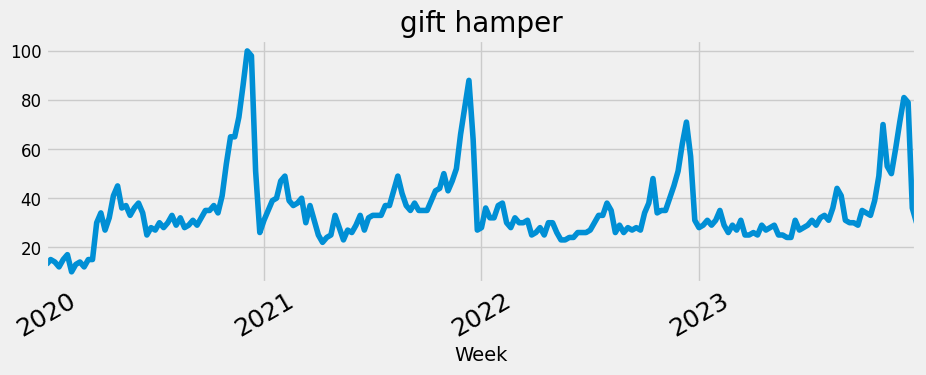

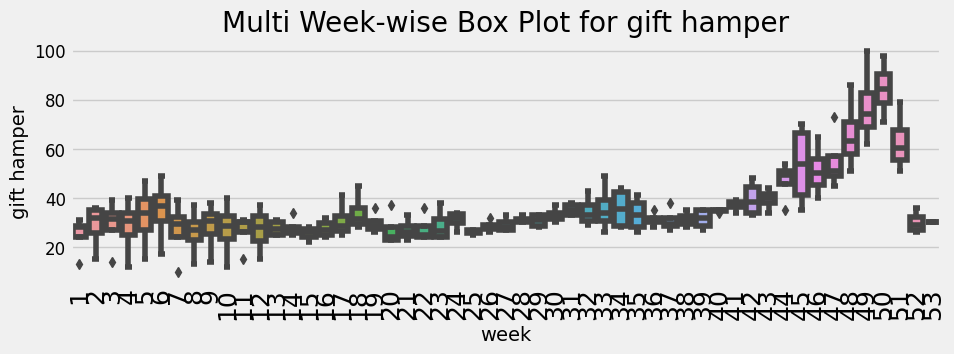

Seasonal on weeks- [13 14 15]


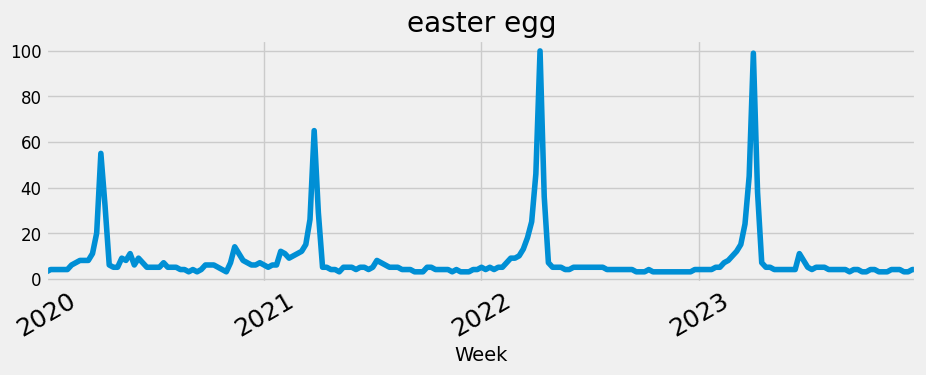

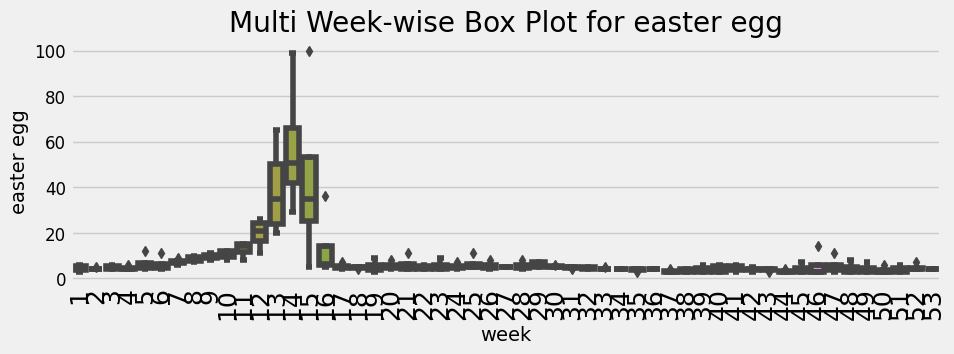

Seasonal on weeks- [ 5  6  7 49 50 51]


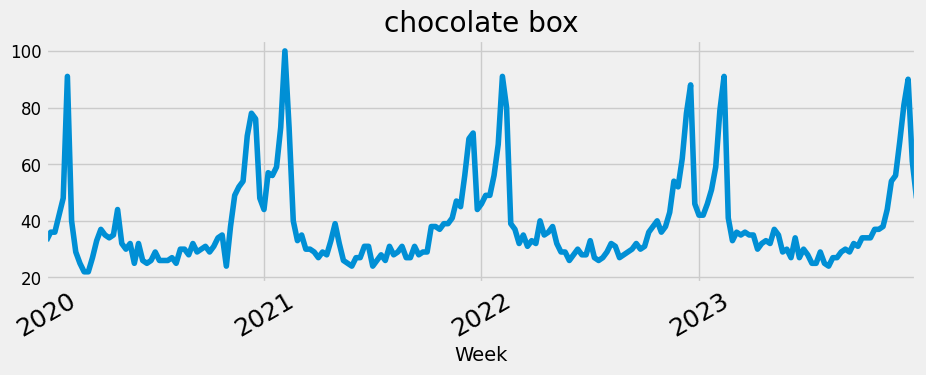

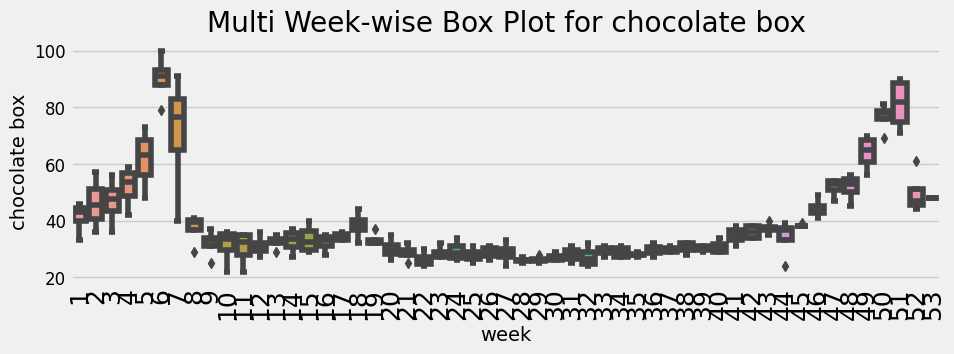

Seasonal on weeks- [45 46 47 48 49 50 51]


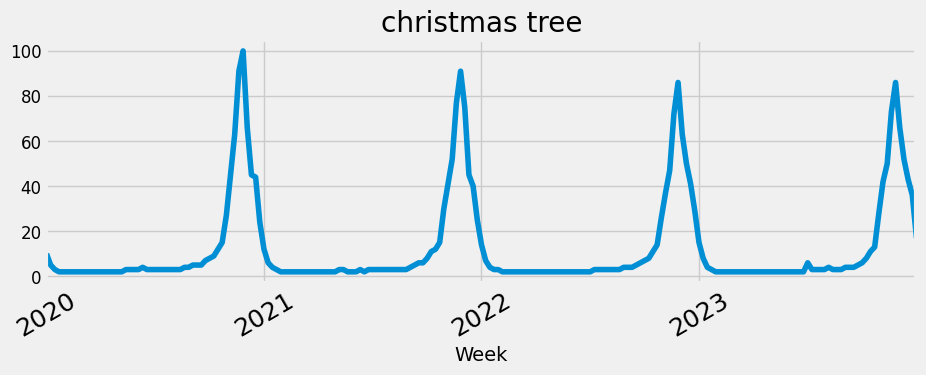

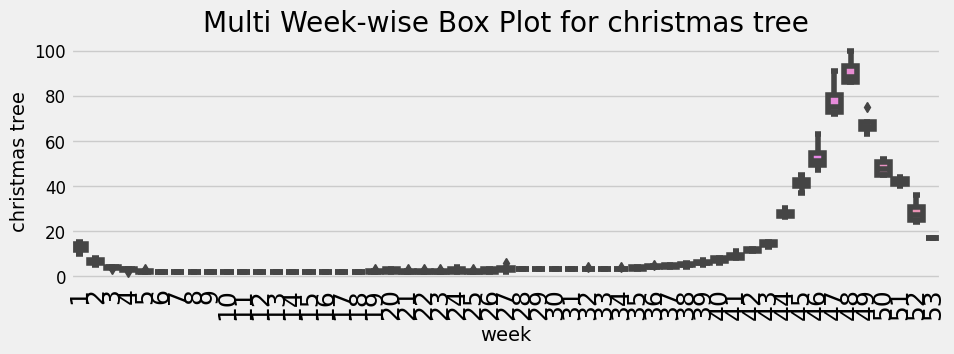

Seasonal on weeks- [ 1  2 51 52]


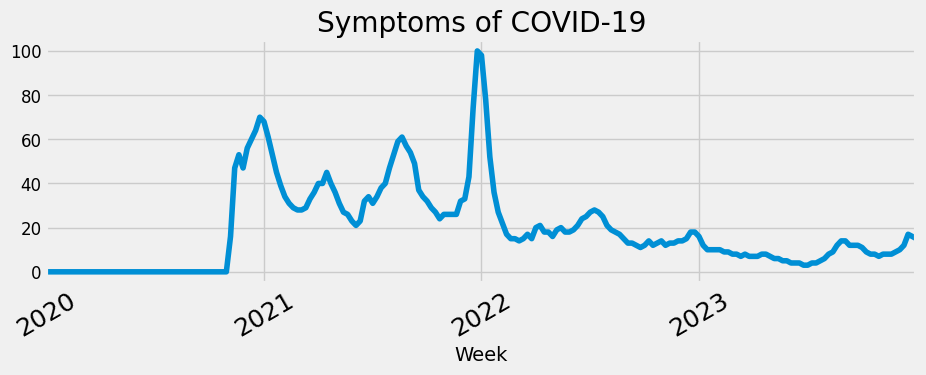

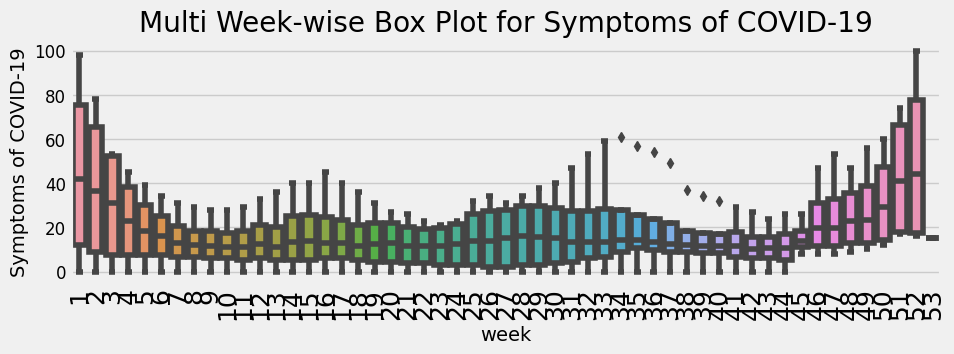

Seasonal on weeks- None


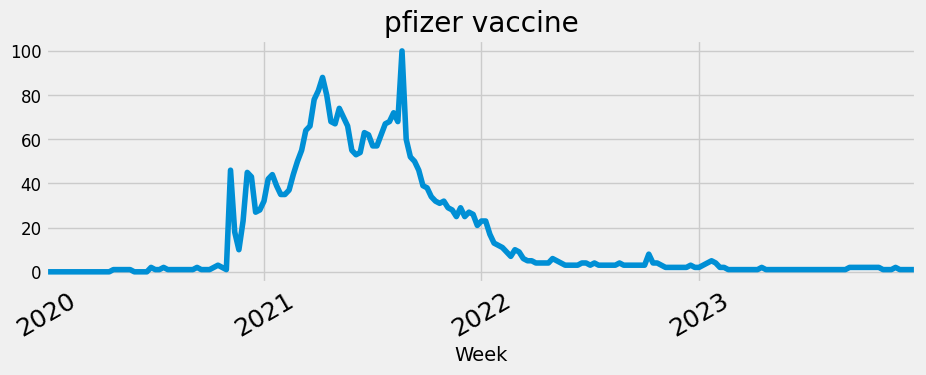

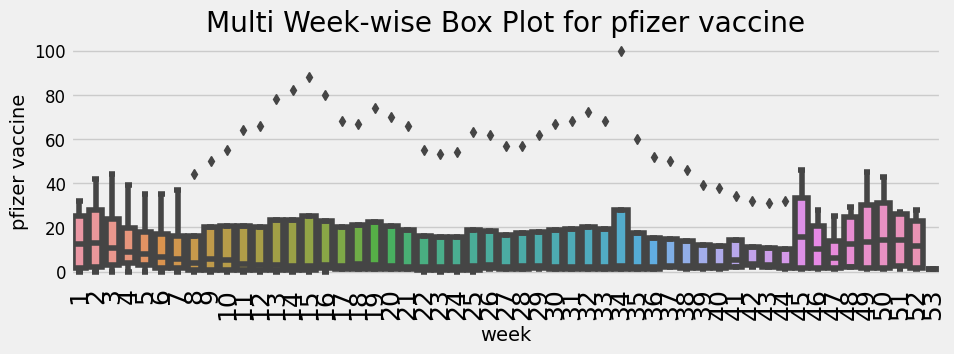

Seasonal on weeks- None


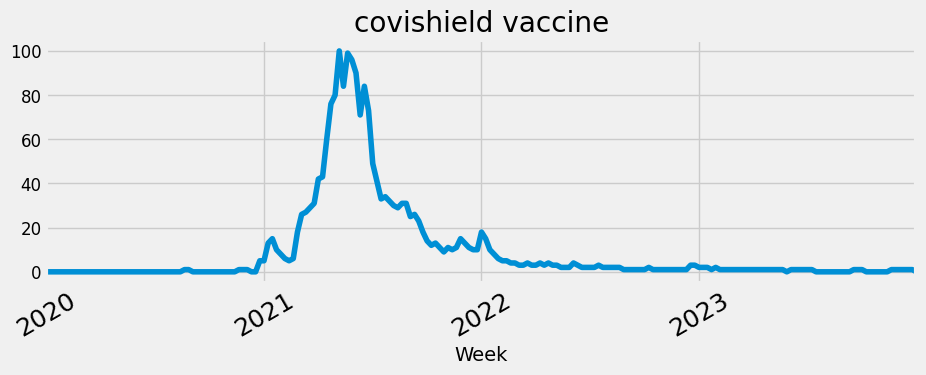

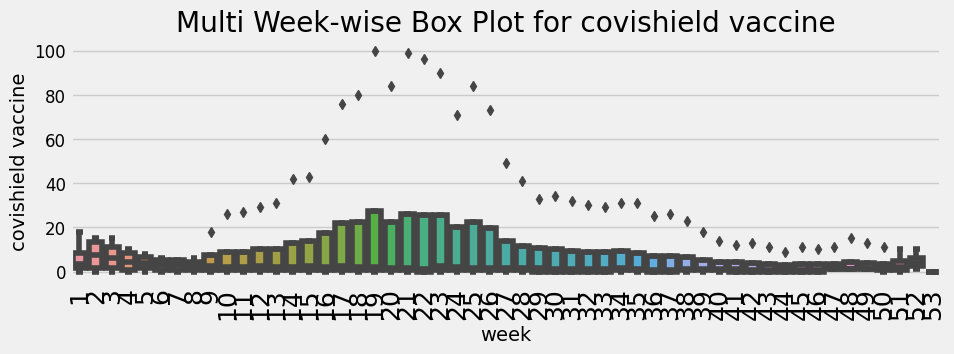

Seasonal on weeks- None


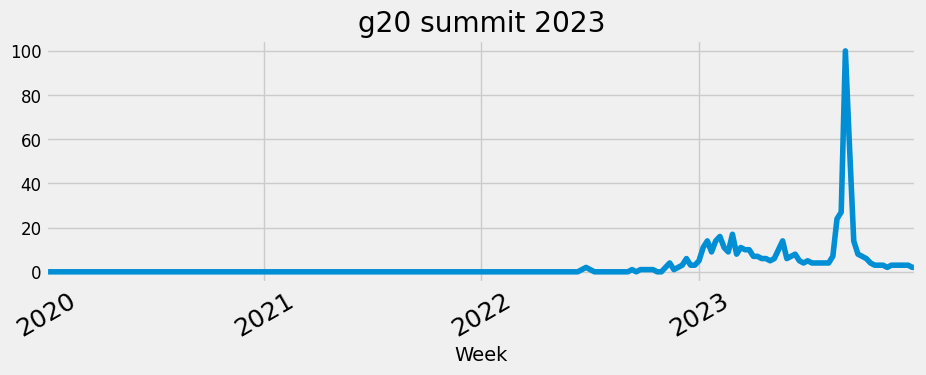

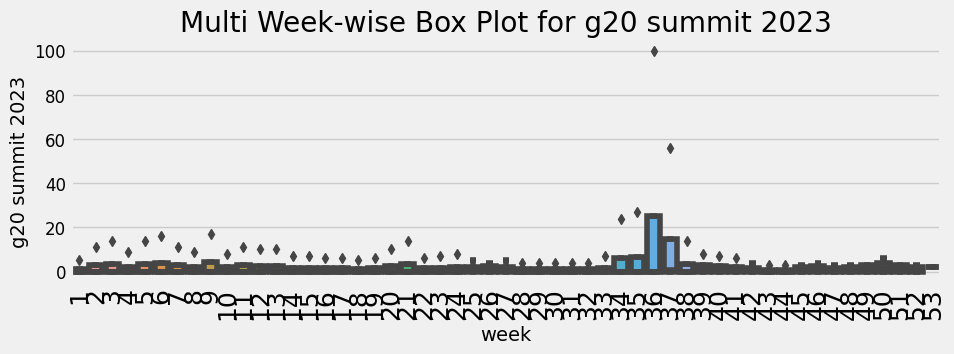

Seasonal on weeks- None


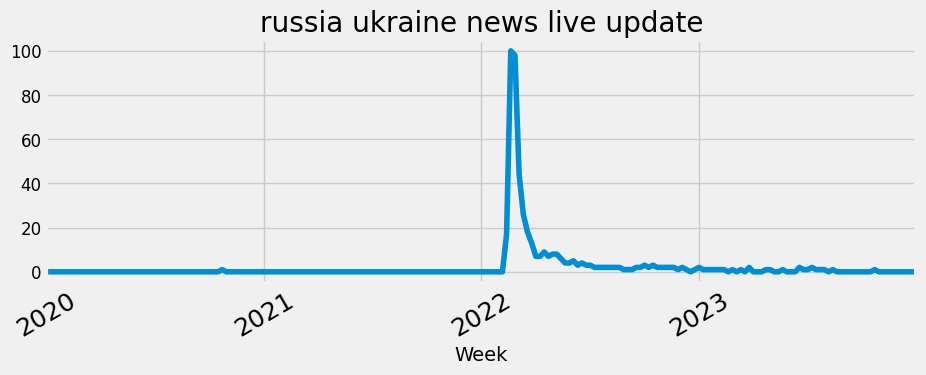

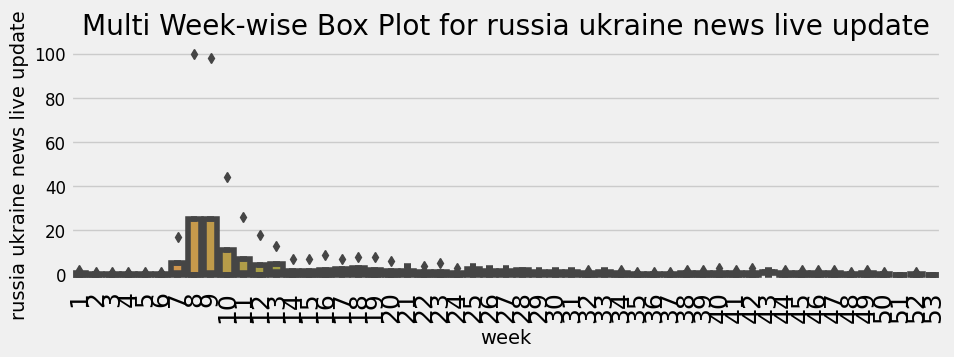

keyword      score      pvalue  lower_bound  \
week                                                                
1    57  Symptoms of COVID-19  55.304028   99.996931   120.161063   
2    58  Symptoms of COVID-19  52.940694   99.804418    85.041897   
5    44         chocolate box  56.287106   99.777490   137.089536   
6    45         chocolate box  68.095402  100.000000   318.287652   
7    46         chocolate box  60.194739   99.997067   195.921695   
...                       ...        ...         ...          ...   
51   25        leather jacket  50.935983   98.295489    65.674415   
52   30       macaroni recipe  57.670953   99.945654   157.224109   
     60  Symptoms of COVID-19  55.699725   99.998657   126.277401   
     26        leather jacket  52.788639   99.686545    83.599414   
     33            tooth ache  50.568549   99.377320    51.603226   

                                                  holidays  
week                                                        
1    57  {New Year Holiday [Scotland] (Observed), Makar...  
2    58  {Republic Day, Martin Luther King Jr. Day, Mak...  
5    44                                                 {}  
6    45                            {Washington's Birthday}  
7    46                            {Washington's Birthday}  
...                                                    ...  
51   25  {New Year's Day, Boxing Day, Christmas Day, Ch...  
52   30  {New Year's Day, Boxing Day, Christmas Day, Ch...  
     60  {New Year's Day, Boxing Day, Christmas Day, Ch...  
     26  {New Year's Day, Boxing Day, Christmas Day, Ch...  
     33  {New Year's Day, Boxing Day, Christmas Day, Ch...  

[61 rows x 5 columns]

In [10]:
def ab_test(seasonal_data, seasonal_weeks, verbose):
    final_seasonal_weeks = pd.DataFrame()

    # scaling to 0 to 1
    scaler = MinMaxScaler().fit(seasonal_data[[keyword+'_cycle']])
    seasonal_data['min_max'] = scaler.transform(seasonal_data[[keyword+'_cycle']])

    # Conducting two-sample t test
    for seasonal_week in seasonal_weeks:
        data_b = seasonal_data[seasonal_data.week==seasonal_week]
        data_a = seasonal_data
        
        # get length of data
        n2 = len(data_b)
        n1 = len(data_a)

        # get variance of data
        var1 = statistics.variance(data_a['min_max'])
        var2 = statistics.variance(data_b['min_max'])
        
        # get mean values
        m1 = data_a['min_max'].mean() # m1 = data_a['min_max'].quantile(0.8)
        m2 = data_b['min_max'].mean() # m2 = data_b['min_max'].quantile(0.1)
        relative_mean = m2-m1
        
        # get pooled standard deviation
        pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
        
        # z critical for 95% confidence
        z_critical = stats.norm.ppf(q = 0.975)
        # Note: We use q = 0.975 to get the desired z-critical value instead of q = 0.95 because the distribution has two tails.
        
        # get lower and upper bounds for confidence interval
        lower_bound = relative_mean-z_critical*pooled_sd/np.sqrt(n1+n2)
        lower_bound = lower_bound*100/m1
        upper_bound = relative_mean+z_critical*pooled_sd/np.sqrt(n1+n2)
        upper_bound = upper_bound*100/m1
        
        # perform 2 student t test
        pvalue = ttest_ind(data_a['min_max'], data_b['min_max'])[1]
        
        # filter data if MVP>20 and data_a and data_b are statistically different
        if pvalue<0.05 and lower_bound>20:
            # print(f'month- {seasonal_month} is seasonal')
            # print('95% confident for Minimum Uplift-', round(lower_bound, 2), '%')
            final_seasonal_weeks = pd.concat([final_seasonal_weeks, 
                                    pd.DataFrame.from_dict([{'week':seasonal_week, 
                                                             'pvalue':(1-pvalue)*100, 
                                                             'lower_bound':lower_bound
                                                             }])])
        
        # months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August',
        #  9:'September', 10:'October', 11:'November', 12:'December'}
        
        if verbose>1:
            plt.errorbar(y=seasonal_week, 
                        x=relative_mean*100/m1, 
                        xerr=(upper_bound-lower_bound)/2,
                        fmt='o', label=seasonal_week)

            plt.vlines(ymin=-2, ymax=55,
                    x=m1*.2*100/m1, 
                    linewidth=2.0,
                    color="red");
            plt.legend()
            plt.title('Confidence Intervals for Uplift')

    if verbose>1:
         plt.show()

    return final_seasonal_weeks


seasonal_data = pd.DataFrame()
rcParams['figure.figsize'] = 10, 3
for keyword in ['rain coat', 'vegan ice cream', 'leather jacket',
       'macaroni recipe', 'tooth ache', 'gift hamper', 'easter egg',
       'chocolate box', 'christmas tree', 'Symptoms of COVID-19',
       'pfizer vaccine', 'covishield vaccine', 'g20 summit 2023',
       'russia ukraine news live update']:
    # keyword='rain coat'
    sample_ = sample.copy()
    sample_['year'] = pd.DatetimeIndex(sample_['Week']).year
    sample_ = sample_[(sample_['year']>=2020) & (sample_.year<2024)]
    sample_['month'] = pd.DatetimeIndex(sample_['Week']).month
    # sample_['week'] = pd.DatetimeIndex(sample_['Week']).week
    sample_['week'] = sample_.groupby(['year']).transform(lambda x: np.arange(1, len(x)+1, 1))['month']

    sample_.index = pd.to_datetime(sample_['Week'])
    sample_.index.freq = 'W'

    gdp_cycle, gdp_trend = hpfilter(sample_[keyword], lamb=129600)
   
    # get data on week frequency
    gdp_cycle_weekly = gdp_cycle.copy()#resample('W').mean()
    # seasonal_component_weekly = seasonal_component.resample('W').mean()

    # get weekly mean of data
    gdp_cycle_weekly = pd.DataFrame(gdp_cycle_weekly)
    gdp_cycle_weekly['year'] = sample_['year']
    # gdp_cycle_weekly['week'] = gdp_cycle_weekly.groupby(['year']).transform(lambda x: np.arange(1, len(x)+1, 1))[keyword+'_cycle']
    gdp_cycle_weekly['week'] = gdp_cycle_weekly.index.isocalendar().week
    gdp_cycle_weekly = gdp_cycle_weekly.reset_index()

    # get overall mean of weekly data
    overall_mean_hp = gdp_cycle_weekly.groupby('week').mean().quantile(0.75)[1]

    # get count of weeks where data > overall mean
    week_count = gdp_cycle_weekly[gdp_cycle_weekly[keyword+'_cycle']>overall_mean_hp].week.value_counts()

    # keep only weeks where count > number of years/2
    eligible_weeks = list(week_count[week_count>2].index.values)
    # print(eligible_weeks)

    # get weekly mean of data
    gdp_weekly_average = gdp_cycle_weekly.groupby(['week'])[keyword+'_cycle'].mean()

    # get seasonal weeks based on weekly mean value > overall mean value across year
    gdp_seasonal_weeks = list(gdp_weekly_average[gdp_weekly_average>overall_mean_hp].index.values)   
    seasonal_weeks = [week for week in gdp_seasonal_weeks if week in eligible_weeks]
    # print(gdp_seasonal_weeks, overall_mean_hp)

    # t test between seasonal months vs rest of the data to make sure seasonal months are unique
    # gdp_cycle = pd.DataFrame(gdp_cycle).reset_index()
    # gdp_cycle['week'] = pd.DatetimeIndex(gdp_cycle['Week']).week

    # run a/b test to get final seasonal months
    seasonal_weeks = ab_test(gdp_cycle_weekly, seasonal_weeks, verbose=1)
    if len(seasonal_weeks)>0:
        seasonal_weeks['keyword'] = keyword
        seasonal_data = pd.concat([seasonal_data, seasonal_weeks])
       
        print('Seasonal on weeks-', seasonal_weeks['week'].values)
    
    else:
        print('Seasonal on weeks- None')

    #  seasonal_component.plot(label='seasonal decompose')
    sample_[keyword].plot(label='original data')

    plt.title(f"{keyword}")
    plt.xticks(rotation=30)
    #  plt.legend();
    plt.show()

    #  plt.figure(figsize=(15,6))
    matplotlib.rcParams['xtick.labelsize'] = 18
    sns.boxplot(x='week', y=keyword, data=sample_).set_title(f"Multi Week-wise Box Plot for {keyword}")
    plt.xticks(rotation=90)
    plt.show()


for year in sample_['year'].unique():
    holidays_list = defaultdict(set)
    for holidays_ in [holidays.UnitedStates(years = int(year)).items(), 
                    holidays.UnitedKingdom(years = int(year)).items(), 
                    holidays.India(years = int(year)).items()]:
        for ptr in holidays_: 
            # print(pd.to_datetime(ptr[0]).week, ptr[0], ptr[1]) 
            holidays_list[pd.to_datetime(ptr[0]).week].add(ptr[1])
for week in range(1, 54):
    if week not in holidays_list.keys():
        holidays_list[week] = set()

seasonal_data['holidays'] = seasonal_data['week'].apply(lambda x: holidays_list[x].union(holidays_list[x+1], holidays_list[x+2]))

scaler = MinMaxScaler()
seasonal_data['lower_bound_scaled'] = scaler.fit_transform(seasonal_data[['lower_bound']])*100
seasonal_data['score'] = (seasonal_data['pvalue']+seasonal_data['lower_bound_scaled'])/2
seasonal_data.reset_index(drop=True).groupby('week').apply(lambda x: x.sort_values('score', ascending=False))[['keyword', 'score', 'pvalue', 'lower_bound', 'holidays']].to_csv('seasonal_data.csv')
seasonal_data.reset_index(drop=True).groupby('week').apply(lambda x: x.sort_values('score', ascending=False))[['keyword', 'score', 'pvalue', 'lower_bound', 'holidays']]
# .sort_values(['week', 'score'], ascending=False)[['week', 'keyword', 'score', 'pvalue', 'lower_bound']]